In [1]:
# ==============================================================================
# 0. 导入必要的库
# ==============================================================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, from_json, to_date, explode, lit, when, create_map,
    year, month, quarter, dayofweek, date_format, hour, concat_ws,
    collect_set, collect_list, size, expr, array_contains, lag,
    count, desc, round,  # Using round directly
    struct, sort_array, monotonically_increasing_id, window as window_fn, slice as spark_slice
)
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, LongType, ArrayType, IntegerType
from pyspark.sql.window import Window as PySparkWindow # Alias to avoid conflict
from pyspark.ml.fpm import FPGrowth
from itertools import chain
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import pandas as pd
import networkx as nx
import warnings
import os

# ==============================================================================
# 0.1. Matplotlib 中文显示和警告处理 及结果保存目录
# ==============================================================================
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    print("SimHei font set for matplotlib.")
except Exception as e1:
    try:
        plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
        plt.rcParams['axes.unicode_minus'] = False
        print("Microsoft YaHei font set for matplotlib.")
    except Exception as e2:
        print(f"Warning: SimHei not found ({e1}), Microsoft YaHei not found ({e2}). Chinese characters may not display correctly.")
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=FutureWarning)

output_dir = "data_mining_results"
os.makedirs(output_dir, exist_ok=True)
charts_dir = os.path.join(output_dir, "charts")
tables_dir = os.path.join(output_dir, "tables")
os.makedirs(charts_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)
print(f"Results will be saved in '{output_dir}' directory.")

# ==============================================================================
# 1. 初始化 SparkSession
# ==============================================================================
spark = SparkSession.builder \
    .appName("ComprehensiveDataMiningPipeline_Full") \
    .config("spark.driver.memory", "256g")  \
    .config("spark.executor.memory", "256g") \
    .config("spark.sql.shuffle.partitions", "10000") \
    .config("spark.sql.legacy.timeParserPolicy", "LEGACY") \
    .getOrCreate()

print("SparkSession Initialized.")
print(f"Spark version: {spark.version}")

# ==============================================================================
# 2. 数据预处理 (生成 df_final_preprocessed)
# ==============================================================================
print("\n--- Section 2: Data Preprocessing ---")
category_to_major_map_dict = {
    "智能手机": "电子产品", "笔记本电脑": "电子产品", "平板电脑": "电子产品", "智能手表": "电子产品", 
    "耳机": "电子产品", "音响": "电子产品", "相机": "电子产品", "摄像机": "电子产品", "游戏机": "电子产品",
    "上衣": "服装", "裤子": "服装", "裙子": "服装", "内衣": "服装", "鞋子": "服装", 
    "帽子": "服装", "手套": "服装", "围巾": "服装", "外套": "服装",
    "零食": "食品", "饮料": "食品", "调味品": "食品", "米面": "食品", "水产": "食品", 
    "肉类": "食品", "蛋奶": "食品", "水果": "食品", "蔬菜": "食品",
    "家具": "家居", "床上用品": "家居", "厨具": "家居", "卫浴用品": "家居",
    "文具": "办公", "办公用品": "办公",
    "健身器材": "运动户外", "户外装备": "运动户外",
    "玩具": "玩具", "模型": "玩具", "益智玩具": "玩具",
    "婴儿用品": "母婴", "儿童课外读物": "母婴",
    "车载电子": "汽车用品", "汽车装饰": "汽车用品"
}
mapping_expr = create_map([lit(x) for x in chain(*category_to_major_map_dict.items())])
product_catalog_path = "product_catalog.json"
print(f"Attempting to read product_catalog.json from: {product_catalog_path}")
try:
    df_catalog_raw = spark.read.option("multiLine", "true").json(product_catalog_path)
    df_products = df_catalog_raw.select(explode(col("products")).alias("product_info")) \
                                .select(
                                    col("product_info.id").alias("product_id"),
                                    col("product_info.category").alias("product_category"),
                                    col("product_info.price").alias("product_unit_price")
                                )
    print("Successfully loaded and processed product_catalog.json.")
except Exception as e:
    print(f"Error reading or processing product_catalog.json: {e}"); spark.stop(); exit()
data_path = "30G_data_new"
print(f"\nAttempting to read main Parquet data from: {data_path}")
df_main_raw = spark.read.parquet(data_path).select("id", "purchase_history")
print("Successfully loaded 'id' and 'purchase_history' from main data.")
purchase_history_schema = StructType([
    StructField("avg_price", DoubleType(), True),
    StructField("items", ArrayType(StructType([StructField("id", LongType(), True)])), True),
    StructField("payment_method", StringType(), True),
    StructField("payment_status", StringType(), True),
    StructField("purchase_date", StringType(), True)
])
df_main_parsed = df_main_raw.withColumn("ph_details", from_json(col("purchase_history"), purchase_history_schema))
df_exploded_purchases = df_main_parsed.select(
    col("id").alias("user_id"), col("ph_details.purchase_date").alias("purchase_date_str"),
    col("ph_details.payment_method").alias("payment_method"), col("ph_details.payment_status").alias("payment_status"),
    col("ph_details.avg_price").alias("transaction_avg_price"), explode(col("ph_details.items")).alias("item_struct")
).select(
    "user_id", "purchase_date_str", "payment_method", "payment_status",
    "transaction_avg_price", col("item_struct.id").alias("purchased_item_id")
)
df_joined = df_exploded_purchases.join(df_products, df_exploded_purchases["purchased_item_id"] == df_products["product_id"], "left")
df_with_major_category = df_joined.withColumn("item_major_category", mapping_expr[col("product_category")]).withColumn(
    "item_major_category", when(col("item_major_category").isNotNull(), col("item_major_category")).otherwise(lit("其他"))
)
df_final_preprocessed = df_with_major_category.withColumn("purchase_date", to_date(col("purchase_date_str"))).select(
    "user_id", "purchase_date", "payment_method", "payment_status", "purchased_item_id", 
    col("product_category").alias("item_minor_category"), "item_major_category", 
    col("product_unit_price").alias("item_unit_price"), "transaction_avg_price"
).cache()
df_final_preprocessed_count = df_final_preprocessed.count()
print("df_final_preprocessed schema:"); df_final_preprocessed.printSchema()
print(f"Count of df_final_preprocessed: {df_final_preprocessed_count}")
print("Data preprocessing complete.")
df_main_raw.unpersist(); df_main_parsed.unpersist(); df_exploded_purchases.unpersist()
df_joined.unpersist(); df_with_major_category.unpersist()
df_products.unpersist(); df_catalog_raw.unpersist()
print("Intermediate pre-processing DataFrames unpersisted.")

SimHei font set for matplotlib.
Results will be saved in 'data_mining_results' directory.


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/20 16:46:12 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/05/20 16:46:13 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


SparkSession Initialized.
Spark version: 3.5.5

--- Section 2: Data Preprocessing ---
Attempting to read product_catalog.json from: product_catalog.json
Successfully loaded and processed product_catalog.json.

Attempting to read main Parquet data from: 30G_data_new
Successfully loaded 'id' and 'purchase_history' from main data.


df_final_preprocessed schema:
root
 |-- user_id: long (nullable = true)
 |-- purchase_date: date (nullable = true)
 |-- payment_method: string (nullable = true)
 |-- payment_status: string (nullable = true)
 |-- purchased_item_id: long (nullable = true)
 |-- item_minor_category: string (nullable = true)
 |-- item_major_category: string (nullable = true)
 |-- item_unit_price: double (nullable = true)
 |-- transaction_avg_price: double (nullable = true)

Count of df_final_preprocessed: 404987101
Data preprocessing complete.
Intermediate pre-processing DataFrames unpersisted.




--- TASK 1: Association Rule Mining for Major Categories ---

Step 1.1: Preparing transaction data...


Total transactions for Task 1 (with >= 2 distinct major categories): 102614467
-RECORD 0---------------------------
 items | [食品, 家居, 电子产品]     
-RECORD 1---------------------------
 items | [服装, 母婴, 食品]         
-RECORD 2---------------------------
 items | [汽车用品, 运动户外, 食品] 
-RECORD 3---------------------------
 items | [母婴, 食品, 家居]         
-RECORD 4---------------------------
 items | [服装, 食品, 电子产品]     
only showing top 5 rows


Step 1.2: Running FPGrowth (minSupport=0.02, minConfidence=0.5)...


25/05/20 16:34:33 WARN FPGrowth: Input data is not cached.                      



Step 1.3: Extracting results...

Frequent Itemsets (Task 1):


+----------------------+--------+------------------+
|items                 |freq    |support_percentage|
+----------------------+--------+------------------+
|[服装]                |58384244|56.9              |
|[食品]                |58107077|56.63             |
|[电子产品]            |58066530|56.59             |
|[家居]                |31074264|30.28             |
|[食品, 服装]          |30051542|29.29             |
|[电子产品, 服装]      |30029034|29.26             |
|[电子产品, 食品]      |29871534|29.11             |
|[玩具]                |24896195|24.26             |
|[办公]                |17080432|16.65             |
|[母婴]                |16843387|16.41             |
|[运动户外]            |16615722|16.19             |
|[汽车用品]            |16385866|15.97             |
|[家居, 服装]          |15416071|15.02             |
|[家居, 食品]          |15338326|14.95             |
|[家居, 电子产品]      |15319611|14.93             |
|[电子产品, 食品, 服装]|13360078|13.02             |
|[玩具, 服装]          |12270032|11.96             |
|[玩具, 

Task 1 Frequent Itemsets saved to CSV at: data_mining_results/tables/task1_frequent_itemsets.csv

Association Rules (Task 1):


+----------------+----------+----------+---------------+------------------+--------+
|rule_str_display|antecedent|consequent|support_percent|confidence_percent|lift_val|
+----------------+----------+----------+---------------+------------------+--------+
|食品 => 服装    |[食品]    |[服装]    |29.29          |51.72             |0.91    |
|电子产品 => 服装|[电子产品]|[服装]    |29.26          |51.71             |0.91    |
|服装 => 食品    |[服装]    |[食品]    |29.29          |51.47             |0.91    |
|电子产品 => 食品|[电子产品]|[食品]    |29.11          |51.44             |0.91    |
|服装 => 电子产品|[服装]    |[电子产品]|29.26          |51.43             |0.91    |
|食品 => 电子产品|[食品]    |[电子产品]|29.11          |51.41             |0.91    |
+----------------+----------+----------+---------------+------------------+--------+



Task 1 Association Rules saved to CSV at: data_mining_results/tables/task1_association_rules.csv

Step 1.4: Filtering rules involving '电子产品'...

Association Rules involving '电子产品':


+----------------+----------+----------+---------------+------------------+--------+
|rule_str_display|antecedent|consequent|support_percent|confidence_percent|lift_val|
+----------------+----------+----------+---------------+------------------+--------+
|电子产品 => 服装|[电子产品]|[服装]    |29.26          |51.71             |0.91    |
|电子产品 => 食品|[电子产品]|[食品]    |29.11          |51.44             |0.91    |
|服装 => 电子产品|[服装]    |[电子产品]|29.26          |51.43             |0.91    |
|食品 => 电子产品|[食品]    |[电子产品]|29.11          |51.41             |0.91    |
+----------------+----------+----------+---------------+------------------+--------+



Task 1 Electronics Rules saved to CSV at: data_mining_results/tables/task1_electronics_rules.csv

Step 1.5: Visualizing rules involving '电子产品'...


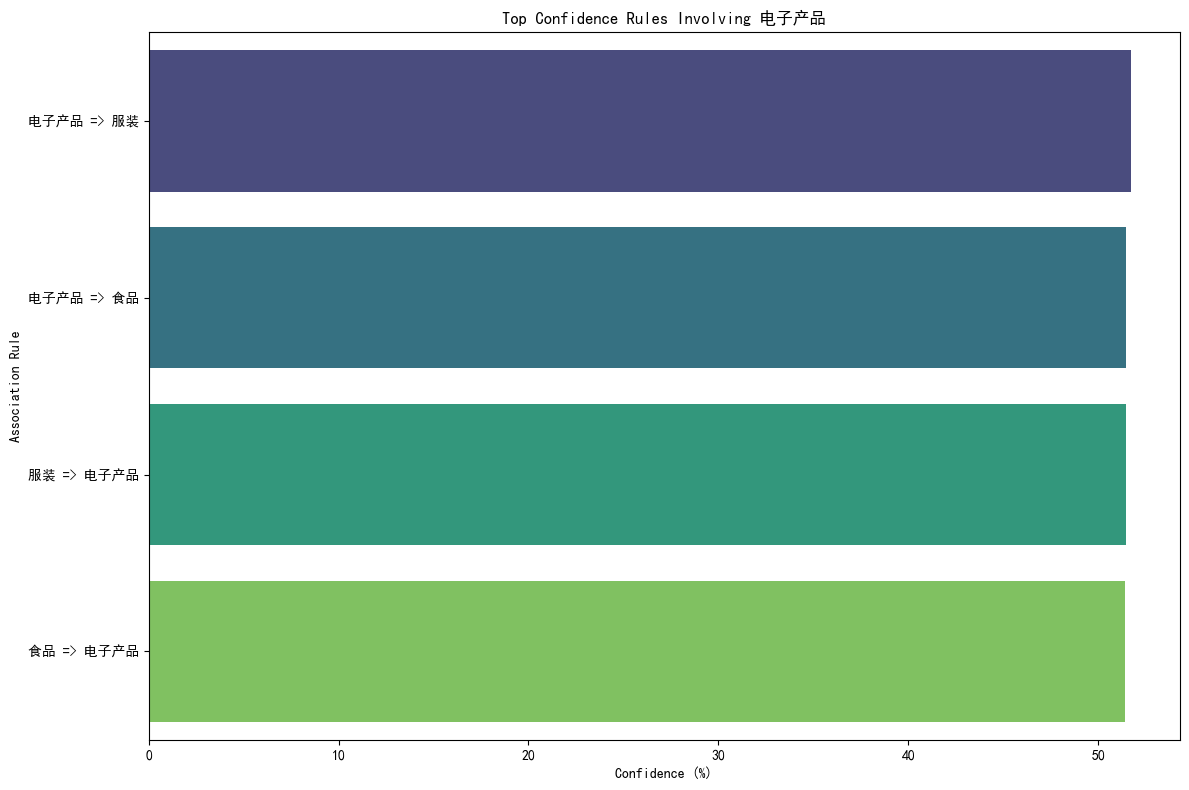

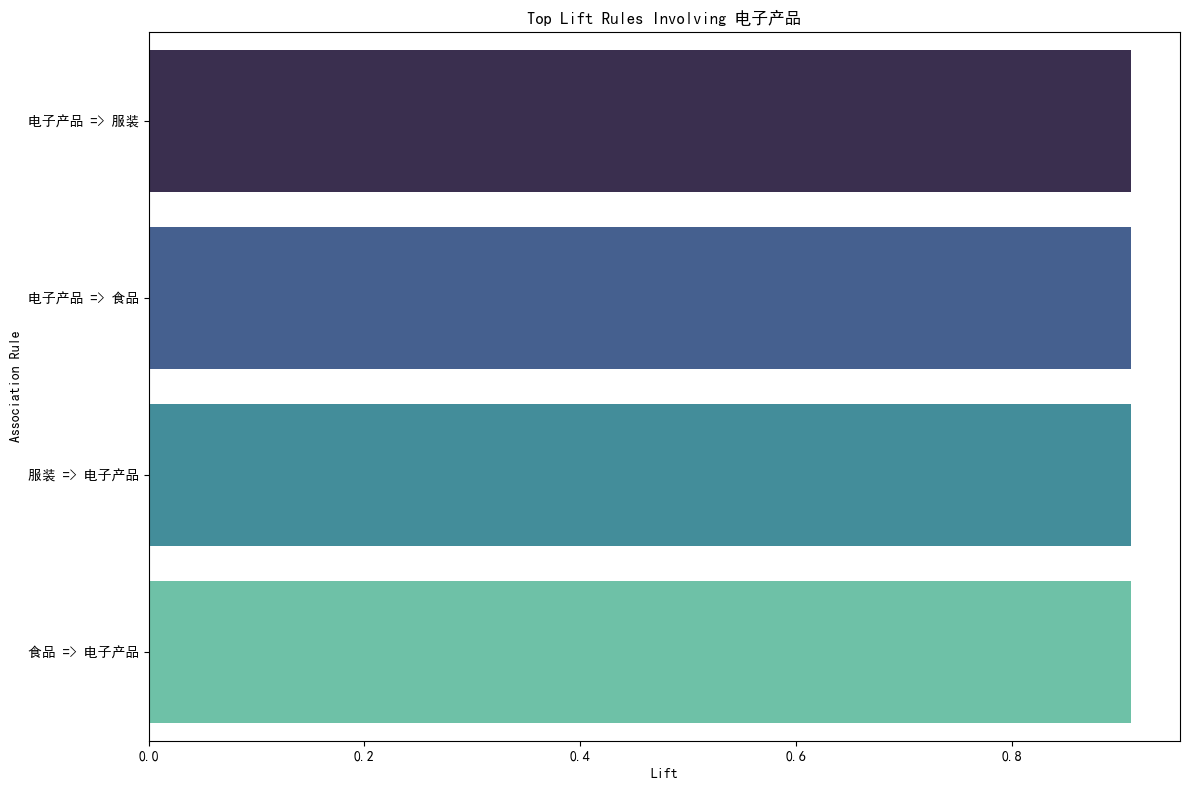

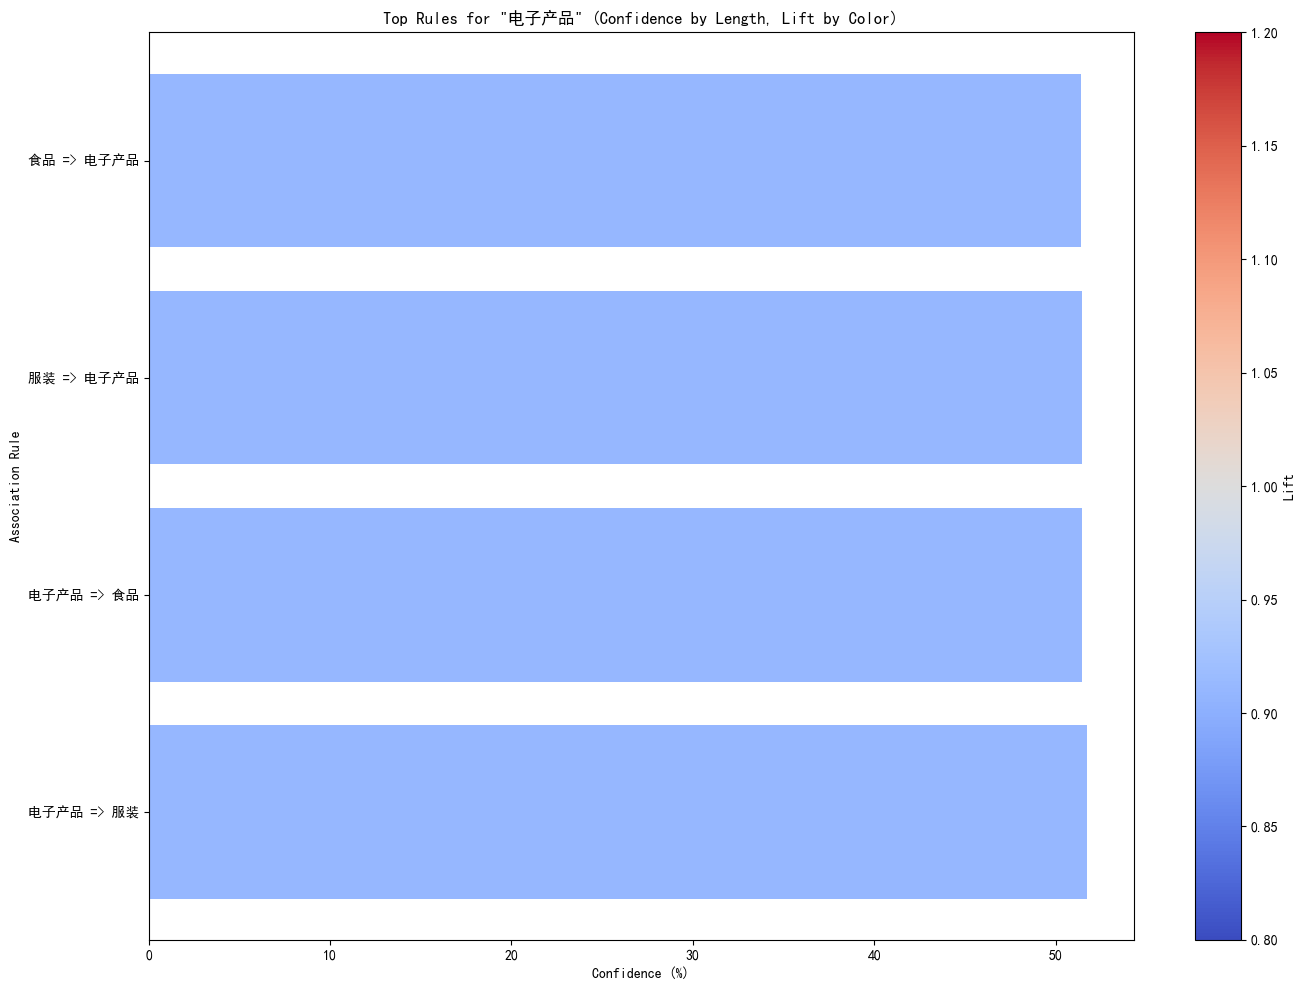

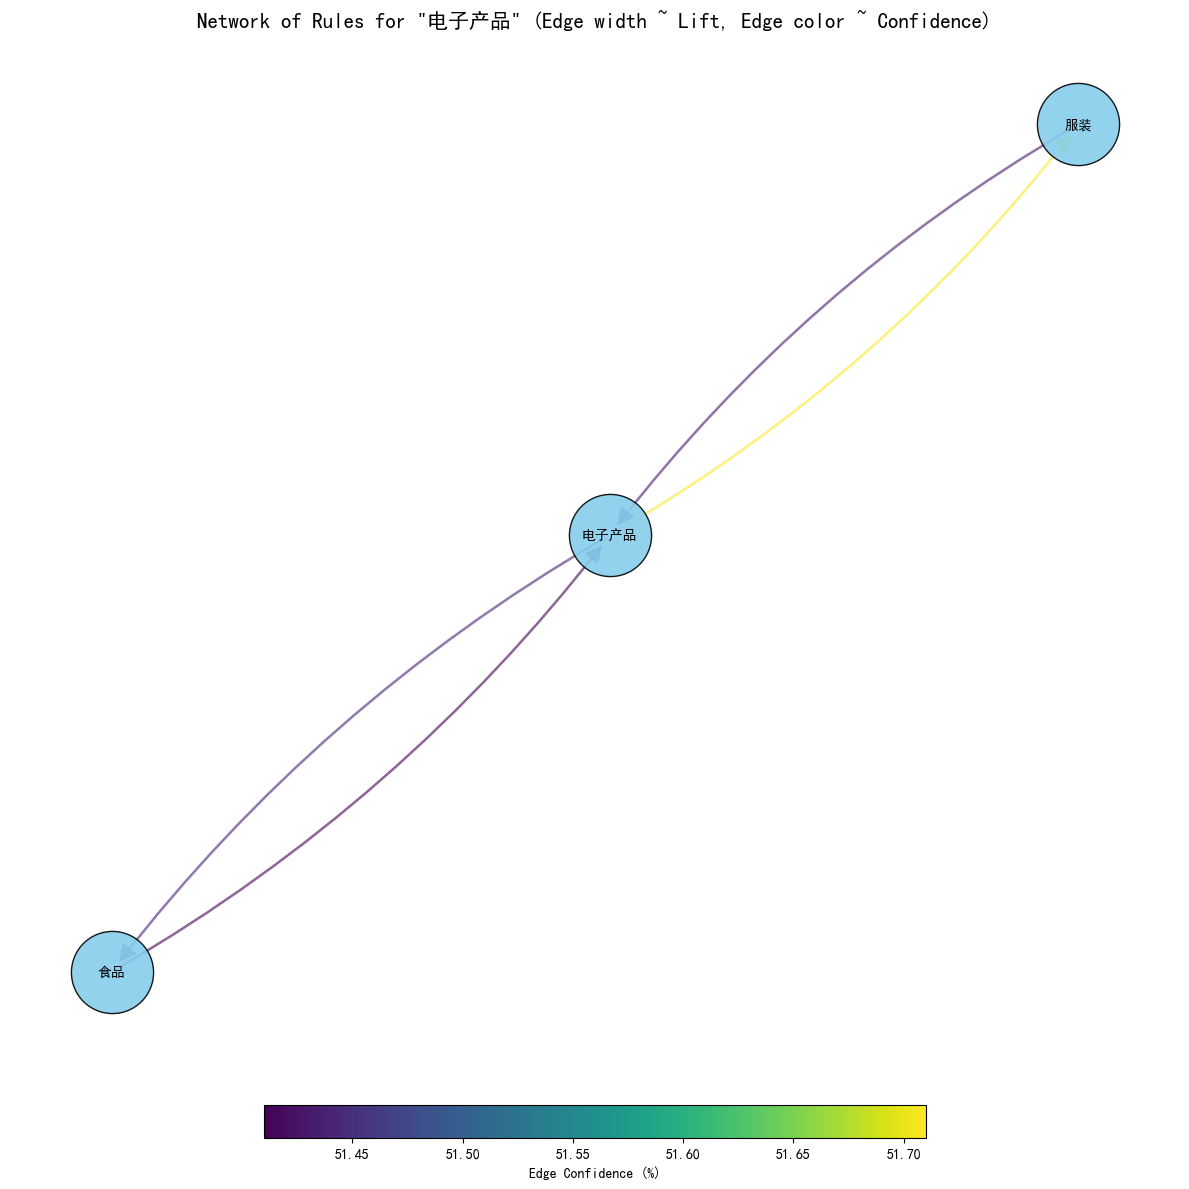

--- TASK 1 Complete ---


In [2]:
# ==============================================================================
# TASK 1: 商品类别关联规则挖掘 (修改后，数组转字符串保存CSV)
# ==============================================================================
print("\n\n--- TASK 1: Association Rule Mining for Major Categories ---")
print("\nStep 1.1: Preparing transaction data...")
baskets_df_task1 = df_final_preprocessed \
    .groupBy("user_id", "purchase_date", "payment_method", "payment_status", "transaction_avg_price") \
    .agg(collect_set("item_major_category").alias("items"))
baskets_df_filtered_task1 = baskets_df_task1.where(size(col("items")) >= 2).cache()
total_transactions_task1 = baskets_df_filtered_task1.count()
print(f"Total transactions for Task 1 (with >= 2 distinct major categories): {total_transactions_task1}")

if total_transactions_task1 > 0:
    baskets_df_filtered_task1.select("items").show(5, truncate=False, vertical=True)
    min_support_task1 = 0.02
    min_confidence_task1 = 0.5
    print(f"\nStep 1.2: Running FPGrowth (minSupport={min_support_task1}, minConfidence={min_confidence_task1})...")
    fpGrowth_task1 = FPGrowth(itemsCol="items", minSupport=min_support_task1, minConfidence=min_confidence_task1)
    model_task1 = fpGrowth_task1.fit(baskets_df_filtered_task1)

    print("\nStep 1.3: Extracting results...")
    # 频繁项集处理
    freq_itemsets_task1_df_raw = model_task1.freqItemsets # 原始DataFrame
    freq_itemsets_task1_df = freq_itemsets_task1_df_raw.withColumn(
        "support_percentage", round((col("freq") / lit(total_transactions_task1)) * 100, 2)
    ).orderBy(desc("freq"))
    print("\nFrequent Itemsets (Task 1):")
    freq_itemsets_task1_df.show(truncate=False)
    
    # 转换为CSV兼容格式
    freq_itemsets_task1_df_for_csv = freq_itemsets_task1_df.withColumn(
        "items_str", concat_ws(", ", col("items")) # 将数组元素用 ", " 连接
    ).select("items_str", "freq", "support_percentage") # 选择需要的列，确保items_str替换items
    freq_itemsets_task1_df_for_csv.write.mode("overwrite").csv(os.path.join(tables_dir, "task1_frequent_itemsets.csv"), header=True)
    print(f"Task 1 Frequent Itemsets saved to CSV at: {os.path.join(tables_dir, 'task1_frequent_itemsets.csv')}")


    # 关联规则处理
    rules_task1_df_raw = model_task1.associationRules # 原始DataFrame
    rules_task1_df = rules_task1_df_raw.withColumn(
        "rule_str_display", expr("concat_ws(' => ', antecedent, consequent)") # 用于显示的规则字符串
    ).withColumn(
        "support_percent", round(col("support") * 100, 2)
    ).withColumn(
        "confidence_percent", round(col("confidence") * 100, 2)
    ).withColumn(
        "lift_val", round(col("lift"), 2)
    ).select("rule_str_display", "antecedent", "consequent", "support_percent", "confidence_percent", "lift_val") \
    .orderBy(desc("confidence_percent"), desc("lift_val")) # 保留原始antecedent和consequent用于后续筛选
    print("\nAssociation Rules (Task 1):")
    rules_task1_df.show(truncate=False)

    # 转换为CSV兼容格式
    rules_task1_df_for_csv = rules_task1_df.withColumn(
        "antecedent_str", concat_ws(", ", col("antecedent"))
    ).withColumn(
        "consequent_str", concat_ws(", ", col("consequent"))
    ).select("rule_str_display", "antecedent_str", "consequent_str", "support_percent", "confidence_percent", "lift_val")
    rules_task1_df_for_csv.write.mode("overwrite").csv(os.path.join(tables_dir, "task1_association_rules.csv"), header=True)
    print(f"Task 1 Association Rules saved to CSV at: {os.path.join(tables_dir, 'task1_association_rules.csv')}")


    target_category_task1 = "电子产品"
    print(f"\nStep 1.4: Filtering rules involving '{target_category_task1}'...")
    # 筛选时使用原始的数组列 antecedent 和 consequent
    rules_electronics_task1_df = rules_task1_df.where(
        array_contains(col("antecedent"), target_category_task1) | array_contains(col("consequent"), target_category_task1)
    )
    print(f"\nAssociation Rules involving '{target_category_task1}':")
    rules_electronics_task1_df.show(truncate=False)
    
    # 转换为CSV兼容格式并保存
    rules_electronics_task1_df_for_csv = rules_electronics_task1_df.withColumn(
        "antecedent_str", concat_ws(", ", col("antecedent"))
    ).withColumn(
        "consequent_str", concat_ws(", ", col("consequent"))
    ).select("rule_str_display", "antecedent_str", "consequent_str", "support_percent", "confidence_percent", "lift_val")
    rules_electronics_task1_df_for_csv.write.mode("overwrite").csv(os.path.join(tables_dir, "task1_electronics_rules.csv"), header=True)
    print(f"Task 1 Electronics Rules saved to CSV at: {os.path.join(tables_dir, 'task1_electronics_rules.csv')}")


    print(f"\nStep 1.5: Visualizing rules involving '{target_category_task1}'...")
    if rules_electronics_task1_df.count() > 0: # 使用原始筛选后的DF进行count
        rules_electronics_pd_task1 = rules_electronics_task1_df.limit(20).toPandas() # 转Pandas前还是用原始DF
        if not rules_electronics_pd_task1.empty:
            # 在Pandas DataFrame中，rule_str_display已经是字符串了，可以直接用于绘图
            # 如果需要，可以从antecedent和consequent (它们在pd df中是list)重新构建rule_str_vis
            rules_electronics_pd_task1['rule_str_vis'] = rules_electronics_pd_task1['rule_str_display']

            plt.figure(figsize=(12, 8))
            sns.barplot(x="confidence_percent", y="rule_str_vis", data=rules_electronics_pd_task1, palette="viridis")
            plt.title(f'Top Confidence Rules Involving {target_category_task1}'); plt.xlabel('Confidence (%)')
            plt.ylabel('Association Rule'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task1_electronics_confidence.png")); plt.show()

            plt.figure(figsize=(12, 8))
            sns.barplot(x="lift_val", y="rule_str_vis", data=rules_electronics_pd_task1, palette="mako")
            plt.title(f'Top Lift Rules Involving {target_category_task1}'); plt.xlabel('Lift')
            plt.ylabel('Association Rule'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task1_electronics_lift.png")); plt.show()
            
            # (Combined Confidence & Lift Plot - 使用 Pandas DataFrame)
            plt.figure(figsize=(14, 10))
            ax_combined = plt.gca() # Get current axes

            min_lift_val_actual = rules_electronics_pd_task1['lift_val'].min() # 实际的最小值，例如0.91
            max_lift_val_actual = rules_electronics_pd_task1['lift_val'].max() # 实际的最大值，例如0.91

            # 定义一个期望的Lift显示范围，例如 0.8 到 1.2，中心为1.0
            # 这样，0.91会落在蓝色区域
            display_min_lift = 0.8 
            display_max_lift = 1.2
            
            # 如果所有实际lift值都相同，我们还是用这个相同的值去归一化
            # 但用于归一化的 Normalize 对象应该使用我们定义的显示范围
            norm_for_coloring = mcolors.Normalize(vmin=display_min_lift, vmax=display_max_lift)
            
            # 对每个bar的lift值进行归一化
            # 由于所有lift值都是0.91，norm_lift_values_for_bars 都会是相同的值
            norm_lift_values_for_bars = norm_for_coloring(rules_electronics_pd_task1['lift_val'].values)
            
            cmap_t1 = plt.cm.coolwarm
            bars_t1 = ax_combined.barh(rules_electronics_pd_task1['rule_str_vis'], 
                                       rules_electronics_pd_task1['confidence_percent'], 
                                       color=cmap_t1(norm_lift_values_for_bars)) # 应用颜色
            
            plt.xlabel('Confidence (%)'); plt.ylabel('Association Rule')
            plt.title(f'Top Rules for "{target_category_task1}" (Confidence by Length, Lift by Color)')
            
            # Colorbar 应该也使用我们定义的显示范围
            sm_t1 = plt.cm.ScalarMappable(cmap=cmap_t1, norm=norm_for_coloring) 
            sm_t1.set_array([]) 
            cbar_t1 = plt.colorbar(sm_t1, ax=ax_combined)
            cbar_t1.set_label('Lift')
            
            plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task1_electronics_combined_confidence_lift.png")); plt.show()
            
            # (Network Graph - 使用 Pandas DataFrame)
            G_task1 = nx.DiGraph(); added_nodes_t1 = set()
            for _, row_pd in rules_electronics_pd_task1.iterrows():
                ante_tuple_t1 = tuple(sorted(row_pd['antecedent'])); cons_tuple_t1 = tuple(sorted(row_pd['consequent']))
                ante_str_t1 = ", ".join(ante_tuple_t1); cons_str_t1 = ", ".join(cons_tuple_t1)
                if ante_str_t1 not in added_nodes_t1: G_task1.add_node(ante_str_t1); added_nodes_t1.add(ante_str_t1)
                if cons_str_t1 not in added_nodes_t1: G_task1.add_node(cons_str_t1); added_nodes_t1.add(cons_str_t1)
                G_task1.add_edge(ante_str_t1, cons_str_t1, weight=row_pd['confidence_percent'], lift=row_pd['lift_val'])

            if G_task1.number_of_nodes() > 0 and G_task1.number_of_edges() > 0:
                plt.figure(figsize=(12, 12))
                ax_network = plt.gca() # Get current axes for the network plot
                
                pos_t1 = nx.spring_layout(G_task1, k=0.8, iterations=30, seed=42)
                edge_widths_t1 = [d['lift'] * 2 for u,v,d in G_task1.edges(data=True)]
                edge_colors_val_t1 = [d['weight'] for u,v,d in G_task1.edges(data=True)] # 'weight' is confidence
                edge_cmap_t1 = plt.cm.viridis
                
                nx.draw_networkx_nodes(G_task1, pos_t1, ax=ax_network, node_size=3500, node_color="skyblue", alpha=0.9, linewidths=1, edgecolors='black')
                edges_t1 = nx.draw_networkx_edges(G_task1, pos_t1, ax=ax_network, width=edge_widths_t1, alpha=0.6, edge_color=edge_colors_val_t1,
                                             edge_cmap=edge_cmap_t1, arrows=True, arrowstyle='-|>', arrowsize=25, connectionstyle='arc3,rad=0.1')
                nx.draw_networkx_labels(G_task1, pos_t1, ax=ax_network, font_size=10, font_weight='bold')
                
                if edges_t1 and edge_colors_val_t1: 
                    if not edge_colors_val_t1:
                        print("Warning: No edge color values for network graph colorbar.")
                    else:
                        # Ensure vmin and vmax are different if there's only one edge or all values are the same
                        vmin_edge = min(edge_colors_val_t1)
                        vmax_edge = max(edge_colors_val_t1)
                        if vmin_edge == vmax_edge:
                            vmax_edge = vmin_edge + 0.1 # Avoid Normalize error with same min/max

                        pc_t1 = plt.cm.ScalarMappable(cmap=edge_cmap_t1, norm=mcolors.Normalize(vmin=vmin_edge, vmax=vmax_edge))
                        pc_t1.set_array([])
                        cbar_edge_t1 = plt.colorbar(pc_t1, ax=ax_network, orientation="horizontal", fraction=0.03, pad=0.04, label="Edge Confidence (%)")
                
                plt.title(f'Network of Rules for "{target_category_task1}" (Edge width ~ Lift, Edge color ~ Confidence)', size=15)
                plt.axis('off')
                plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task1_electronics_network.png")); plt.show()
            else:
                print("Not enough nodes/edges for Task 1 network graph.")
        else: print(f"No rules involving '{target_category_task1}' to visualize.")
    baskets_df_filtered_task1.unpersist()
else:
    print("No transactions with >= 2 items for Task 1 FPGrowth.")
print("--- TASK 1 Complete ---")



--- TASK 2 (REVISED AGAIN): Payment Method and Product Category Distribution Analysis (No FP-Growth) ---

--- Task 2.1: Payment Method and MAJOR Product Category Distribution ---

--- Sub-task 2.1.a: Payment Method Distribution for each MAJOR Category ---

Counts of (Major Category, Payment Method) pairs (Task 2.1.a):


+-------------------+--------------+--------------+
|item_major_category|payment_method|purchase_count|
+-------------------+--------------+--------------+
|办公               |储蓄卡        |2816582       |
|办公               |现金          |2815238       |
|办公               |银联          |2814696       |
|办公               |信用卡        |2812546       |
|办公               |支付宝        |2811039       |
|办公               |云闪付        |2810396       |
|办公               |微信支付      |2808011       |
|家居               |云闪付        |5493265       |
|家居               |储蓄卡        |5492538       |
|家居               |现金          |5491739       |
|家居               |银联          |5491711       |
|家居               |信用卡        |5491318       |
|家居               |微信支付      |5490715       |
|家居               |支付宝        |5488203       |
|服装               |储蓄卡        |12438873      |
|服装               |现金          |12433678      |
|服装               |银联          |12433035      |
|服装               |云闪付        |12432494  


Payment Method Percentage within each Major Category (Task 2.1.a):


+-------------------+--------------+--------------+------------------------+------------------------------+
|item_major_category|payment_method|purchase_count|total_majorcat_purchases|payment_percentage_in_majorcat|
+-------------------+--------------+--------------+------------------------+------------------------------+
|办公               |储蓄卡        |2816582       |19688508                |14.31                         |
|办公               |现金          |2815238       |19688508                |14.3                          |
|办公               |银联          |2814696       |19688508                |14.3                          |
|办公               |信用卡        |2812546       |19688508                |14.29                         |
|办公               |支付宝        |2811039       |19688508                |14.28                         |
|办公               |云闪付        |2810396       |19688508                |14.27                         |
|办公               |微信支付      |2808011       |19688508   


Visualizing payment distribution for ALL major categories (Task 2.1.a)...


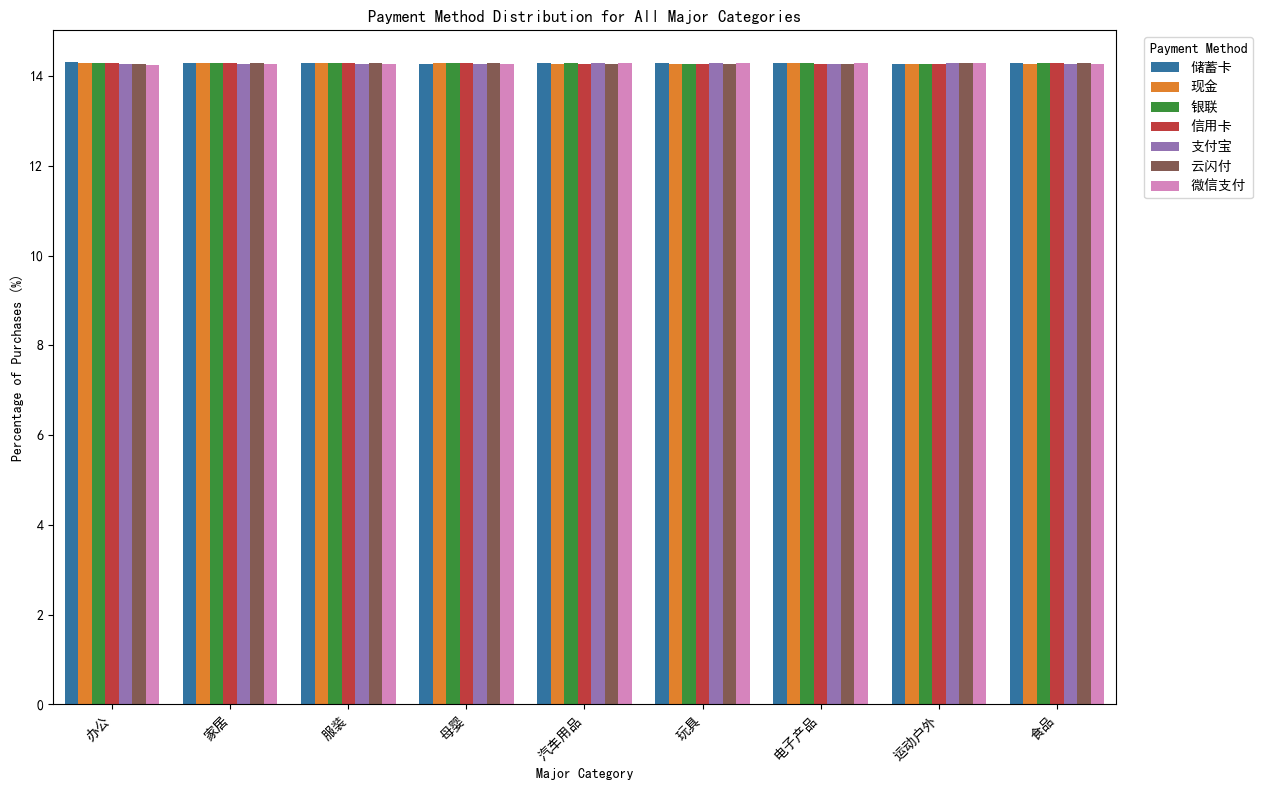


--- Sub-task 2.1.b: Major Category Distribution for each Payment Method ---

Major Category Purchase Percentage within each Payment Method (Task 2.1.b):


+--------------+-------------------+--------------+-----------------------+------------------------------+
|payment_method|item_major_category|purchase_count|total_payment_purchases|majorcat_percentage_in_payment|
+--------------+-------------------+--------------+-----------------------+------------------------------+
|云闪付        |服装               |12432494      |57855147               |21.49                         |
|云闪付        |食品               |12341743      |57855147               |21.33                         |
|云闪付        |电子产品           |12325114      |57855147               |21.3                          |
|云闪付        |家居               |5493265       |57855147               |9.49                          |
|云闪付        |玩具               |4258150       |57855147               |7.36                          |
|云闪付        |办公               |2810396       |57855147               |4.86                          |
|云闪付        |母婴               |2772700       |57855147               


Visualizing top major categories for each payment method (Task 2.1.b)...


/tmp/ipykernel_3467702/2913446093.py:51: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  payment_colors_task2_1b = plt.cm.get_cmap('tab10', len(all_payment_methods_task2_1b)) if all_payment_methods_task2_1b else None


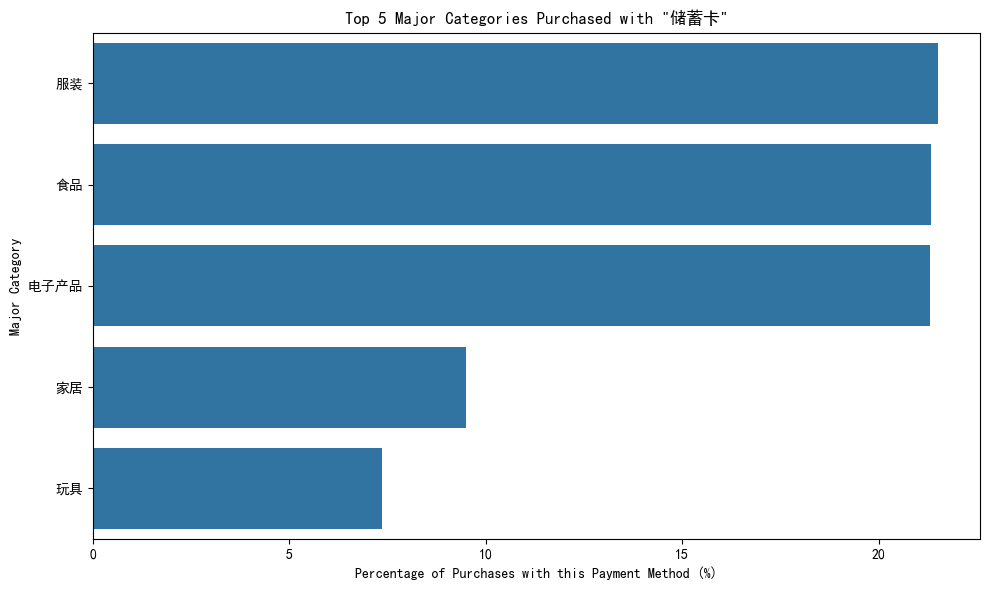

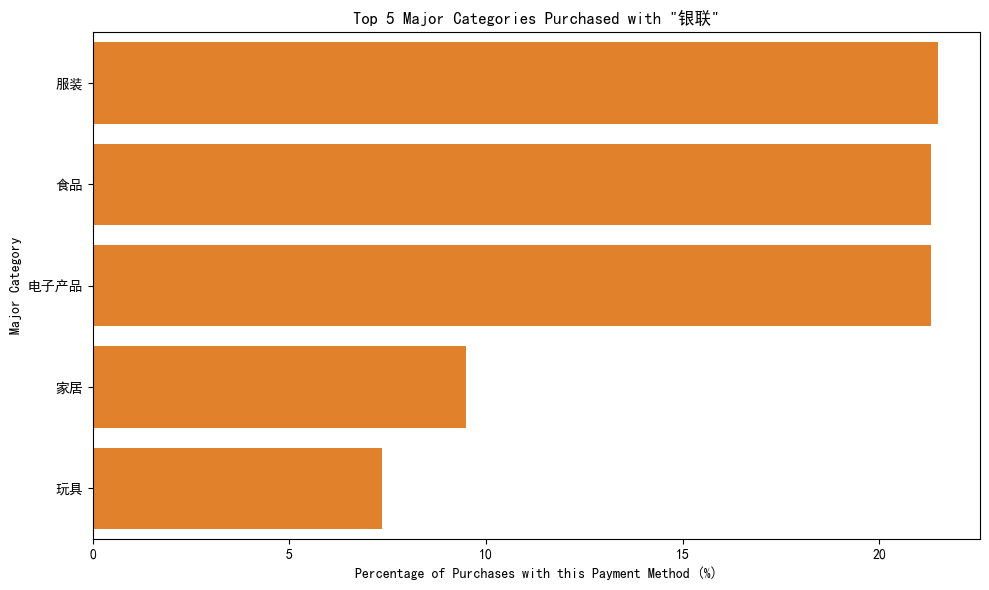

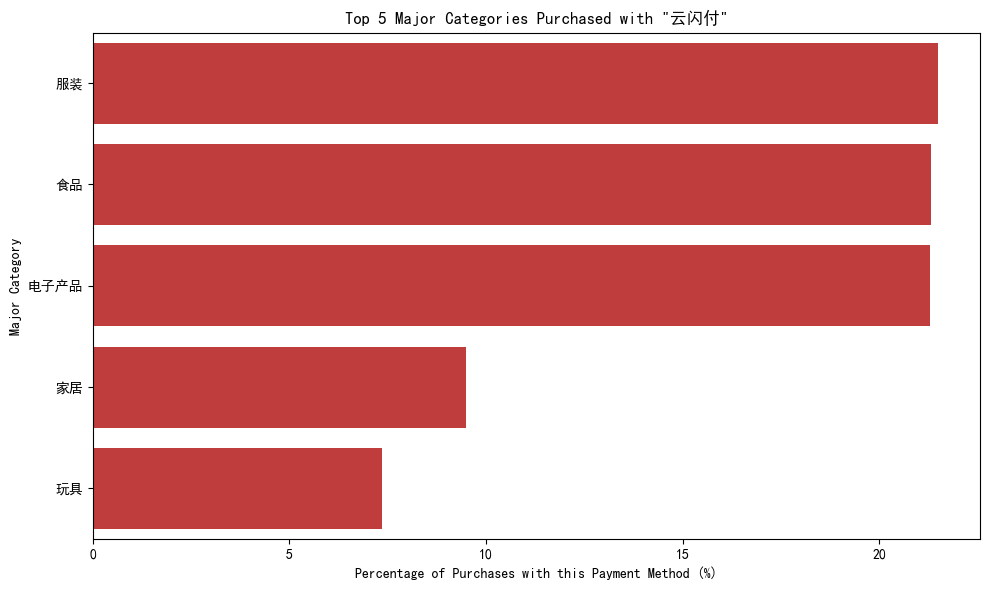

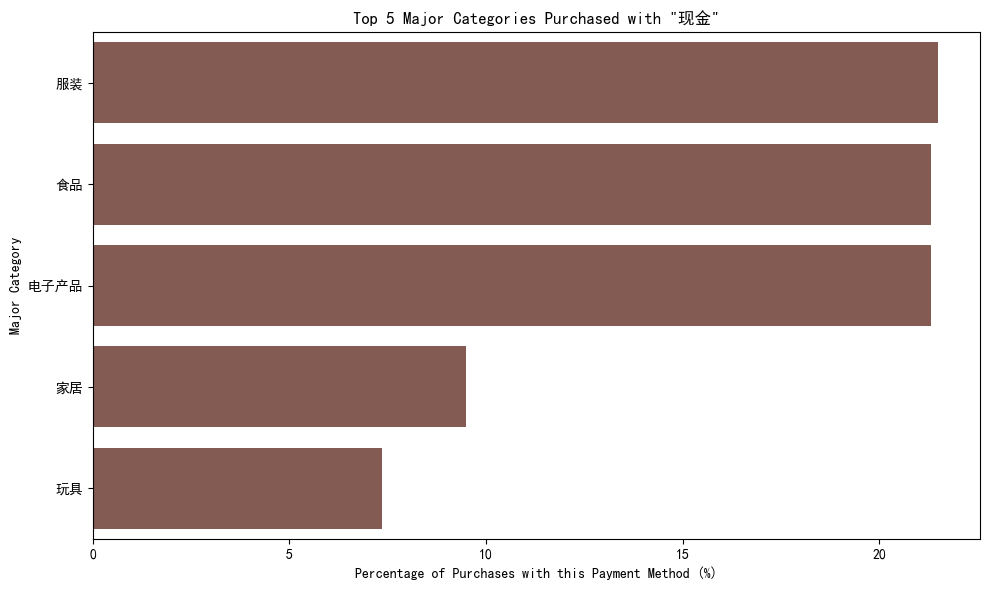

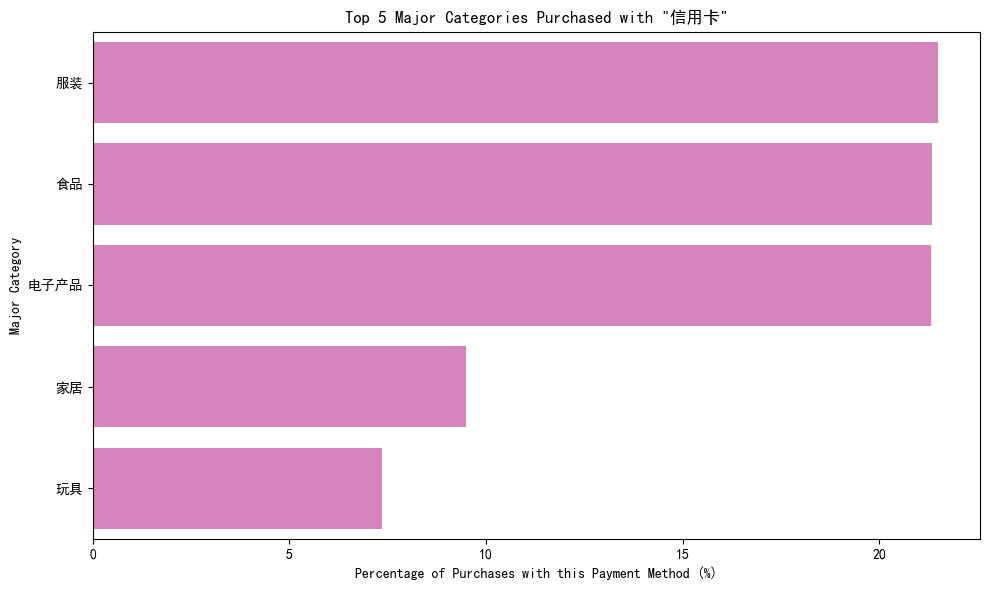

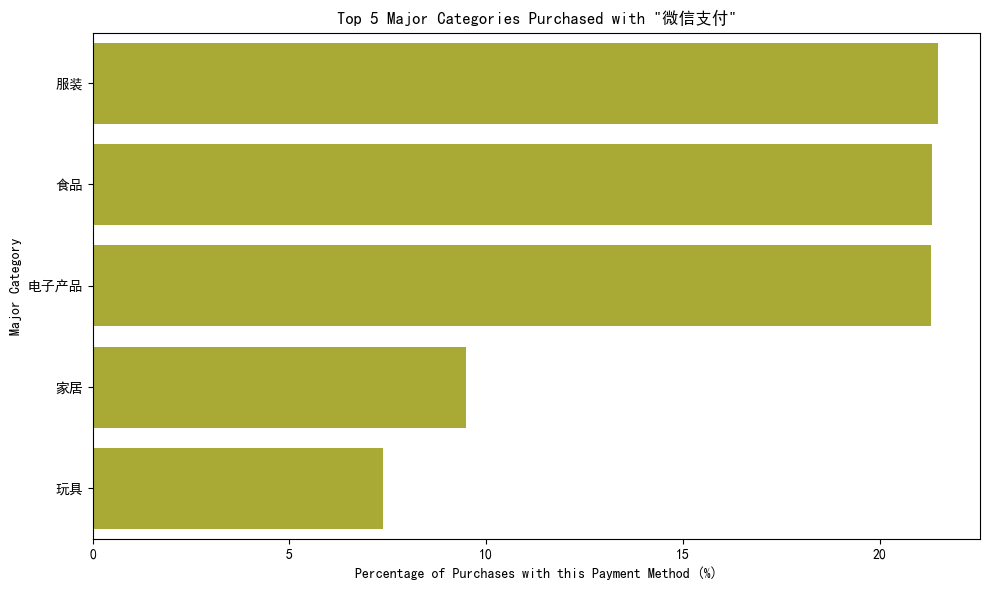

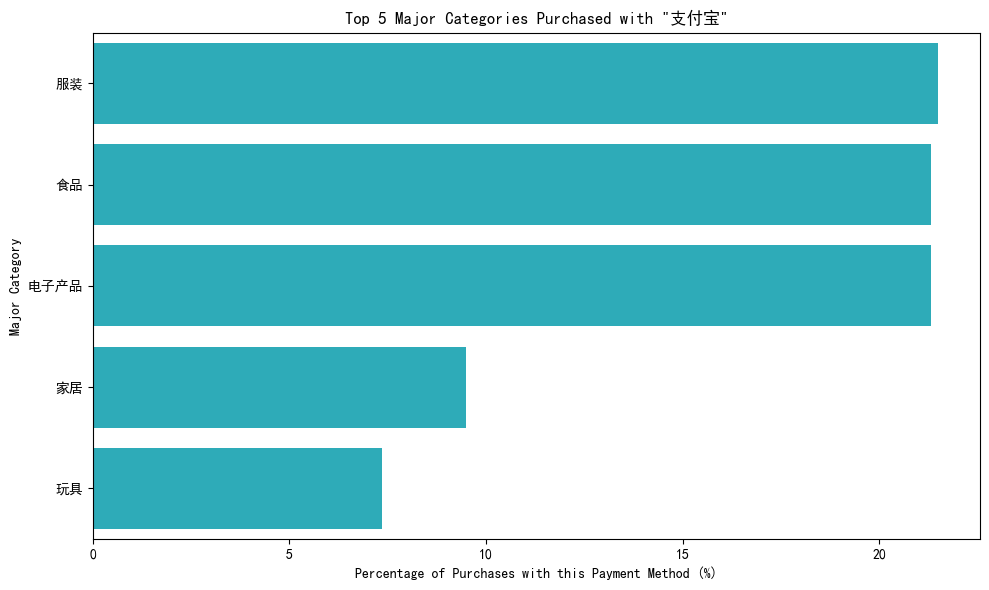


--- Task 2.2: Payment Method and MINOR Product Category Distribution Analysis ---

--- Sub-task 2.2.a: Payment Method Distribution for each Minor Category ---

Counts of (Minor Category, Payment Method) pairs (Top 50 - Task 2.2.a):


+-------------------+--------------+--------------+
|item_minor_category|payment_method|purchase_count|
+-------------------+--------------+--------------+
|上衣               |云闪付        |1316153       |
|上衣               |银联          |1313690       |
|上衣               |储蓄卡        |1313330       |
|上衣               |现金          |1313052       |
|上衣               |支付宝        |1312613       |
|上衣               |信用卡        |1312056       |
|上衣               |微信支付      |1311637       |
|健身器材           |微信支付      |1408434       |
|健身器材           |银联          |1407382       |
|健身器材           |支付宝        |1406935       |
|健身器材           |云闪付        |1405735       |
|健身器材           |信用卡        |1405513       |
|健身器材           |现金          |1405351       |
|健身器材           |储蓄卡        |1404381       |
|儿童课外读物       |现金          |1395441       |
|儿童课外读物       |云闪付        |1395400       |
|儿童课外读物       |支付宝        |1394586       |
|儿童课外读物       |信用卡        |1394250       |
|儿童课外读物       |银联        


Payment Method Percentage within each Minor Category (Top 50 - Task 2.2.a):


+-------------------+--------------+--------------+------------------------+------------------------------+
|item_minor_category|payment_method|purchase_count|total_category_purchases|payment_percentage_in_category|
+-------------------+--------------+--------------+------------------------+------------------------------+
|上衣               |云闪付        |1316153       |9192531                 |14.32                         |
|上衣               |储蓄卡        |1313330       |9192531                 |14.29                         |
|上衣               |银联          |1313690       |9192531                 |14.29                         |
|上衣               |现金          |1313052       |9192531                 |14.28                         |
|上衣               |支付宝        |1312613       |9192531                 |14.28                         |
|上衣               |微信支付      |1311637       |9192531                 |14.27                         |
|上衣               |信用卡        |1312056       |9192531    


Visualizing payment distribution for top 7 minor categories (Task 2.2.a)...


Top 7 minor categories for visualization: ['模型', '围巾', '文具', '卫浴用品', '水果', '饮料', '智能手机']


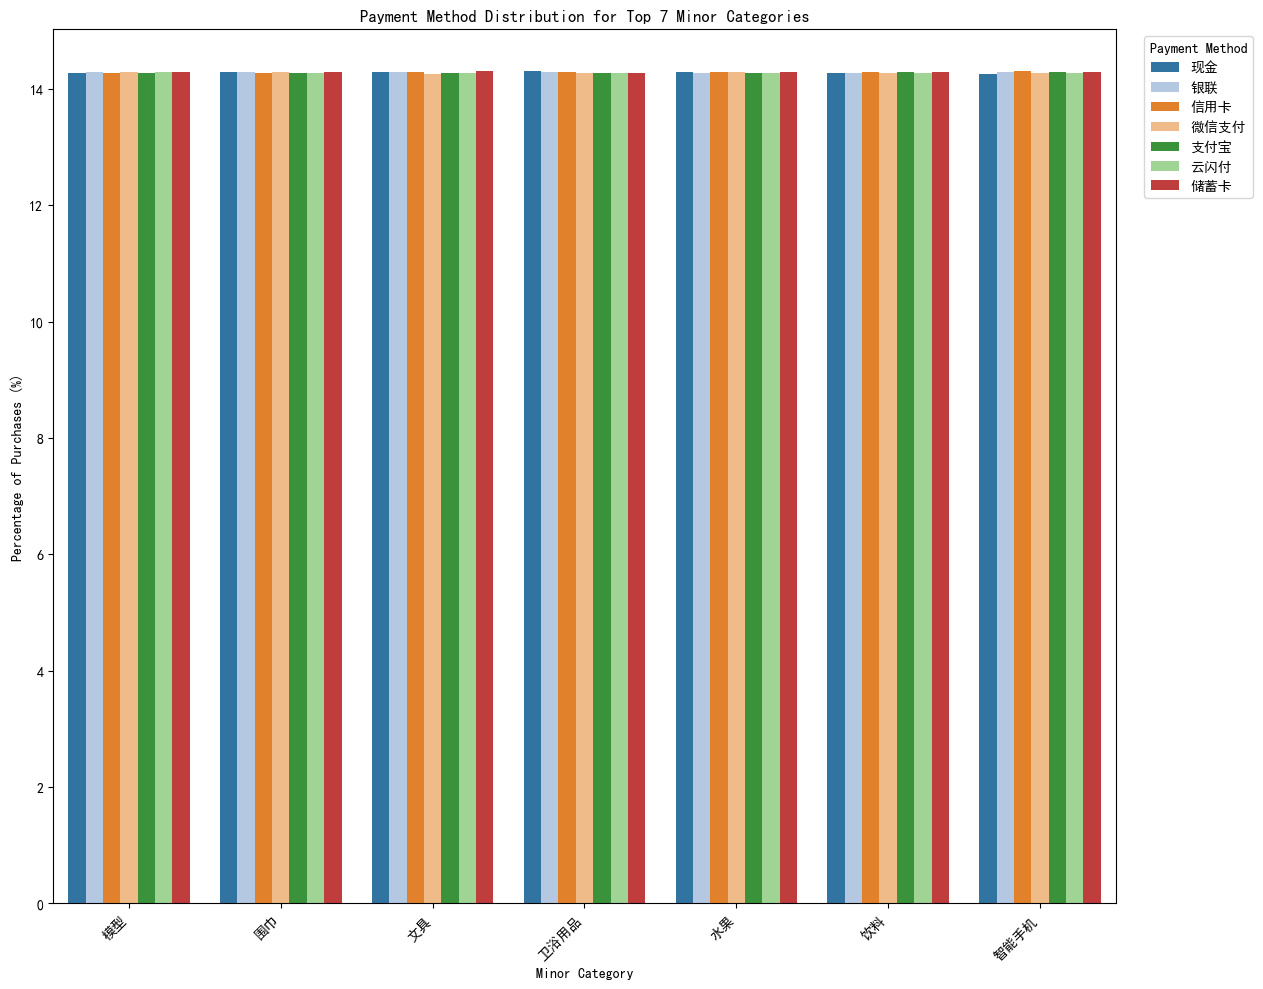


--- Sub-task 2.2.b: Minor Category Distribution for each Payment Method ---

Minor Category Purchase Percentage within each Payment Method (Top 50 - Task 2.2.b):


+--------------+-------------------+--------------+-----------------------+------------------------------+
|payment_method|item_minor_category|purchase_count|total_payment_purchases|category_percentage_in_payment|
+--------------+-------------------+--------------+-----------------------+------------------------------+
|云闪付        |模型               |1517449       |57855147               |2.62                          |
|云闪付        |围巾               |1509517       |57855147               |2.61                          |
|云闪付        |文具               |1503299       |57855147               |2.6                           |
|云闪付        |卫浴用品           |1474736       |57855147               |2.55                          |
|云闪付        |水果               |1467563       |57855147               |2.54                          |
|云闪付        |饮料               |1456340       |57855147               |2.52                          |
|云闪付        |智能手机           |1451298       |57855147               |2


Visualizing top minor categories for each payment method (Task 2.2.b)...


/tmp/ipykernel_3467702/2913446093.py:97: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  payment_colors_task2_2b = plt.cm.get_cmap('tab10', len(all_payment_methods_task2_2b)) if all_payment_methods_task2_2b else None


All payment methods for visualization: ['储蓄卡', '银联', '云闪付', '现金', '信用卡', '微信支付', '支付宝']


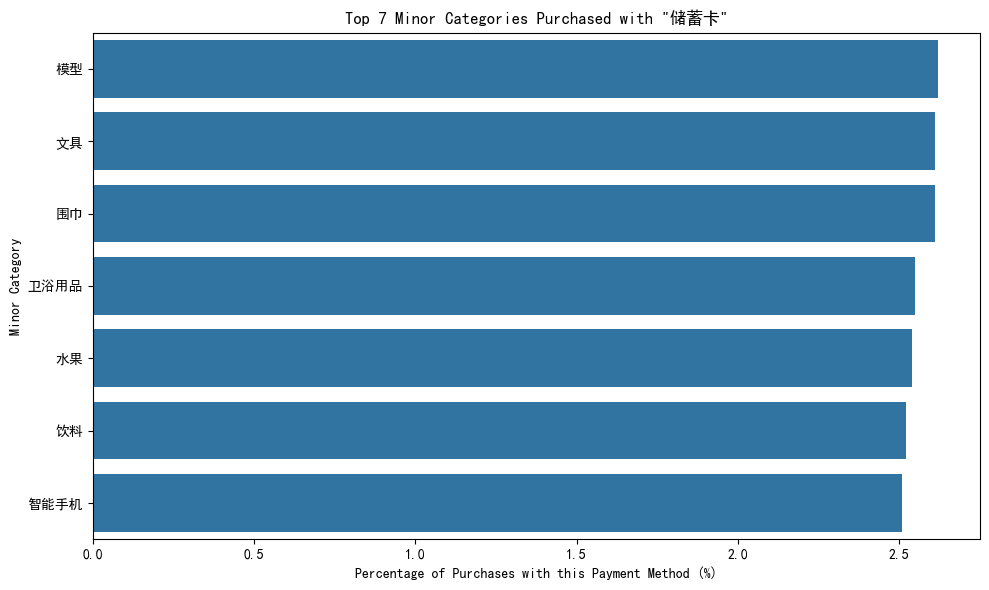

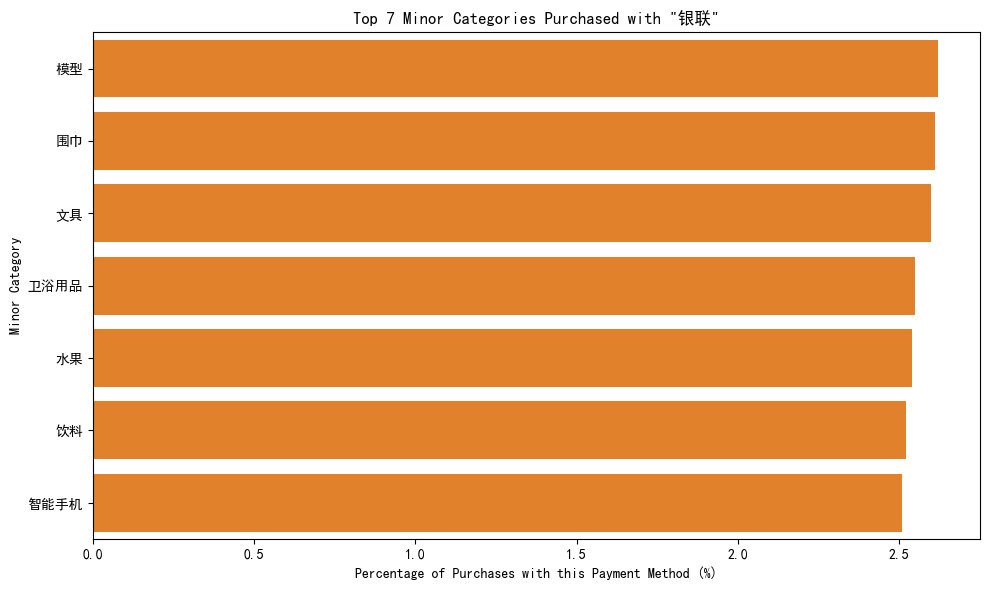

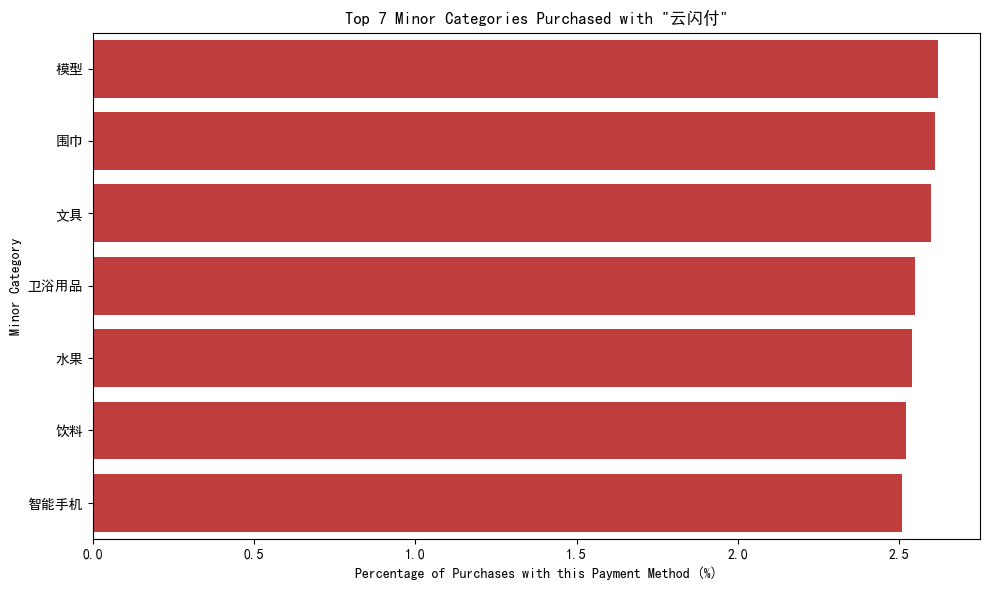

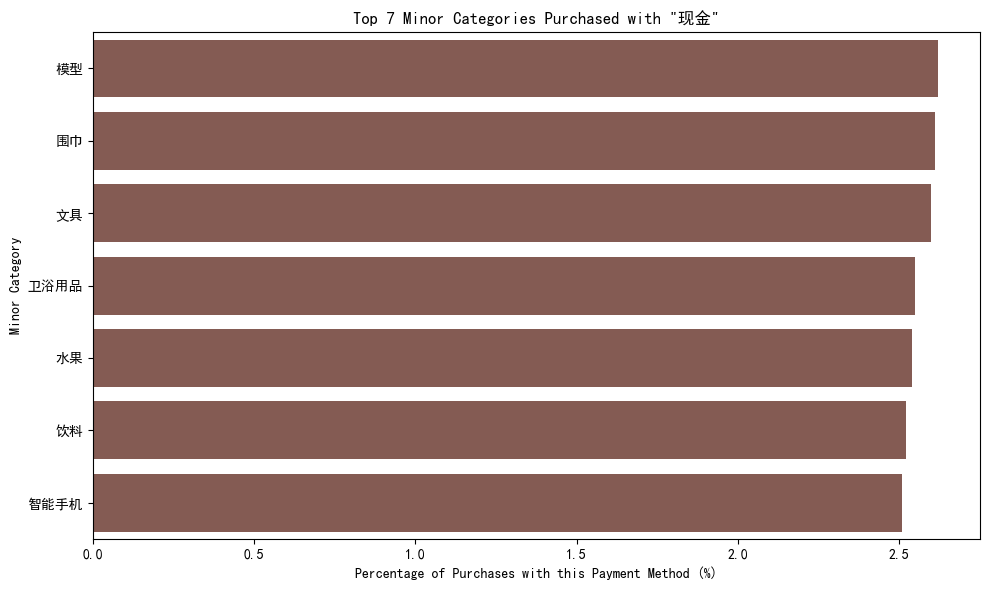

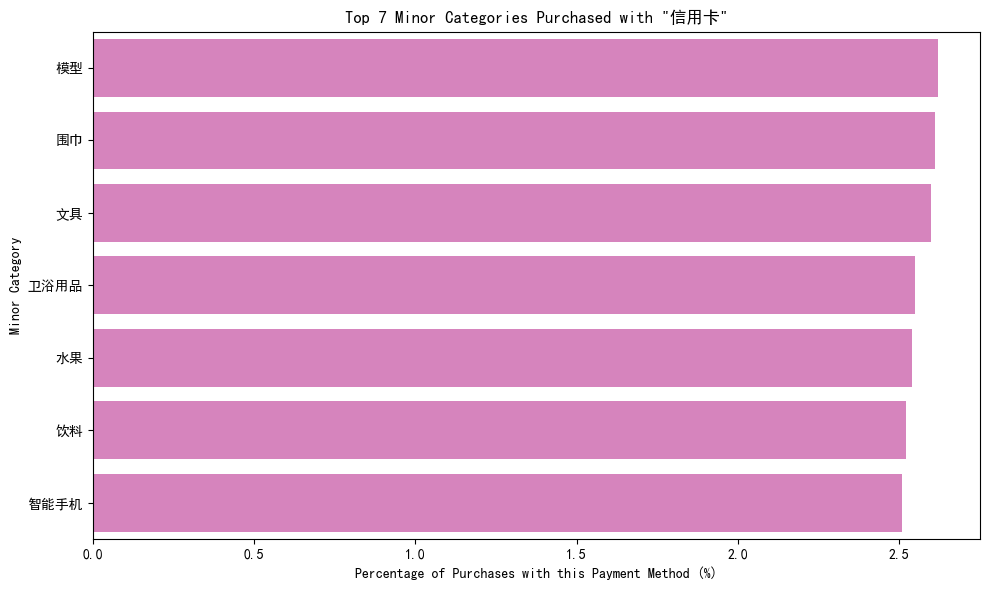

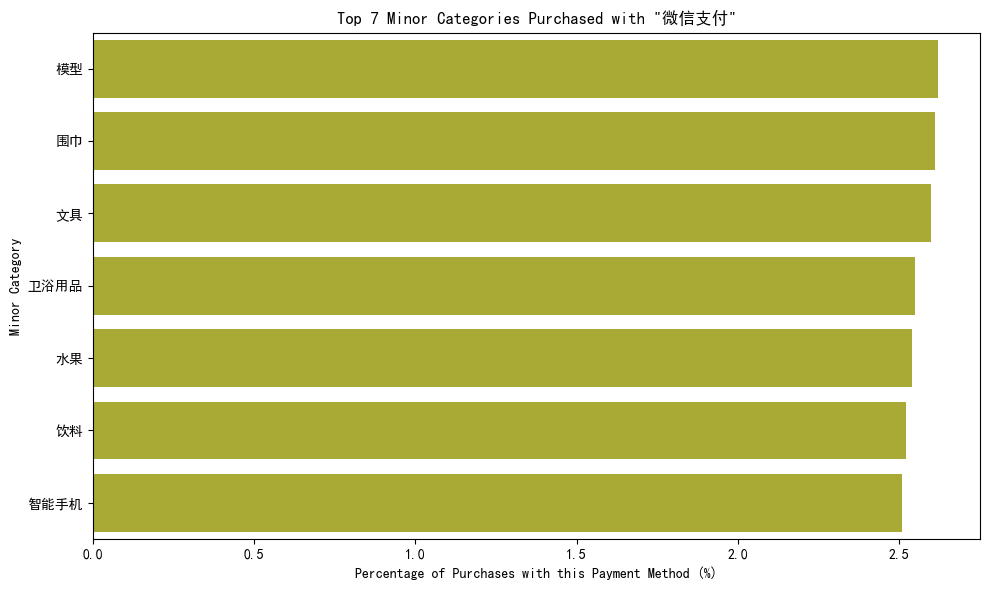

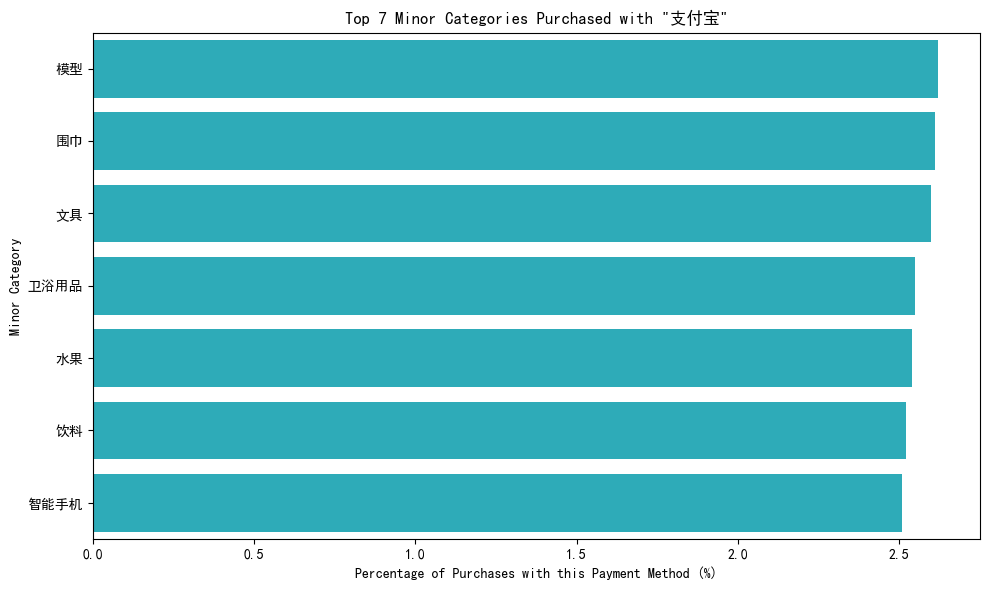


--- Task 2.3: Preferred Payment Method for High-Value Items (item_unit_price > 5000) ---
Step 2.3.1: Filtering for high-value item purchases (item_unit_price > 5000)...
Number of individual high-value items purchased: 35275385

Step 2.3.2: Analyzing payment method distribution for high-value items...

Preferred Payment Methods for High-Value Items (Task 2.3):


+--------------+--------------+
|payment_method|purchase_count|
+--------------+--------------+
|现金          |5041263       |
|银联          |5040744       |
|信用卡        |5039768       |
|支付宝        |5039679       |
|储蓄卡        |5039390       |
|微信支付      |5038351       |
|云闪付        |5036190       |
+--------------+--------------+



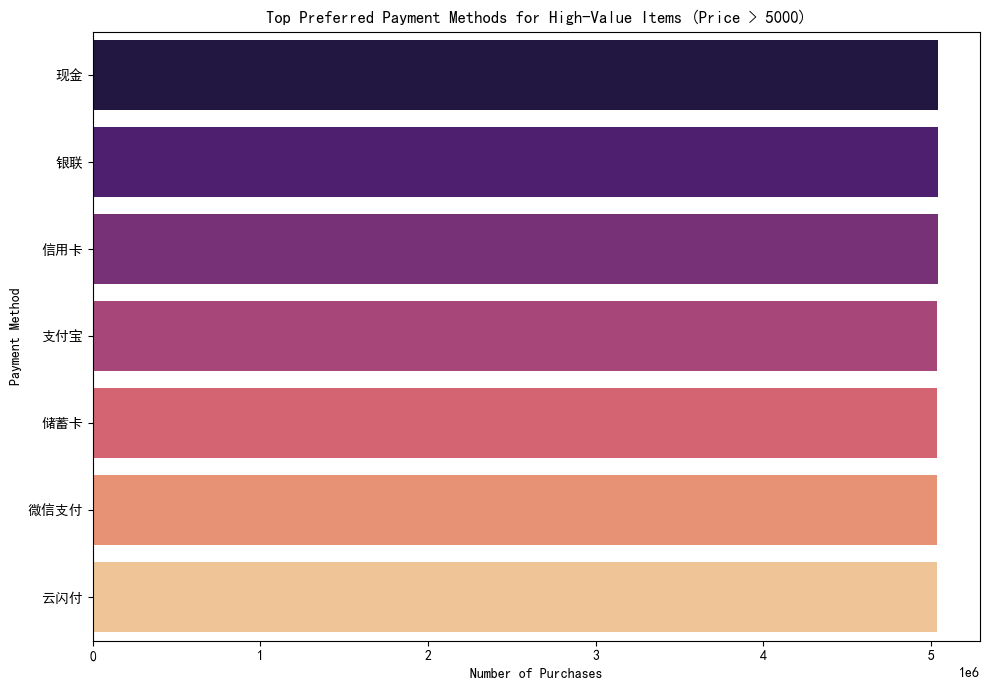


--- Sub-task 2.4: Heatmap of Payment Method Percentage for High-Value MINOR Categories (Price > 5000) ---
Found high-value items. Proceeding with heatmap generation for Task 2.4...

Payment Method Percentage within each High-Value Minor Category (Task 2.4 - Sample):


+-------------------+--------------+---------------------------------+
|item_minor_category|payment_method|payment_percentage_in_hv_category|
+-------------------+--------------+---------------------------------+
|家具               |云闪付        |14.3                             |
|家具               |信用卡        |14.28                            |
|家具               |储蓄卡        |14.29                            |
|家具               |微信支付      |14.28                            |
|家具               |支付宝        |14.29                            |
|家具               |现金          |14.27                            |
|家具               |银联          |14.29                            |
|平板电脑           |云闪付        |14.26                            |
|平板电脑           |信用卡        |14.3                             |
|平板电脑           |储蓄卡        |14.28                            |
|平板电脑           |微信支付      |14.29                            |
|平板电脑           |支付宝        |14.28                            |
|平板电脑

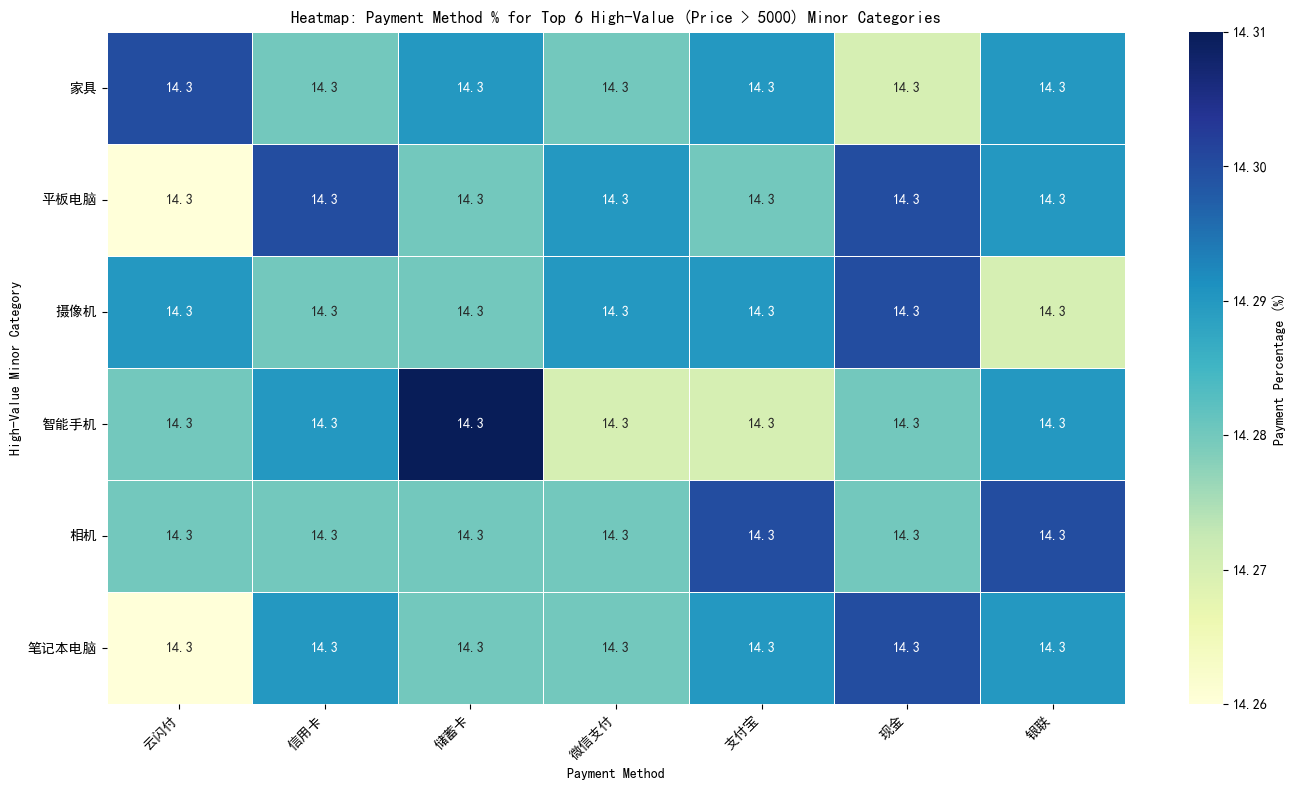

--- TASK 2 Complete ---


In [3]:
# ==============================================================================
# TASK 2: 支付方式与商品类别的分布统计分析
# ==============================================================================
print("\n\n--- TASK 2 (REVISED AGAIN): Payment Method and Product Category Distribution Analysis (No FP-Growth) ---")

# 我们直接使用 df_final_preprocessed，它每行是一个购买的商品项
# 并包含 payment_method, item_major_category, item_minor_category

# --- Task 2.1: 支付方式与商品大类的分布分析 ---
print("\n--- Task 2.1: Payment Method and MAJOR Product Category Distribution ---")

# --- Sub-task 2.1.a: 每个商品大类的支付方式分布 ---
print("\n--- Sub-task 2.1.a: Payment Method Distribution for each MAJOR Category ---")
majorcat_payment_counts_df_task2_1a = df_final_preprocessed.groupBy("item_major_category", "payment_method") \
    .agg(count("*").alias("purchase_count")) \
    .orderBy("item_major_category", desc("purchase_count"))
print("\nCounts of (Major Category, Payment Method) pairs (Task 2.1.a):"); majorcat_payment_counts_df_task2_1a.show(50, truncate=False)
majorcat_payment_counts_df_task2_1a.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_1a_majorcat_payment_counts.csv"), header=True)

total_purchases_per_major_category_df_task2_1a = df_final_preprocessed.groupBy("item_major_category") \
    .agg(count("*").alias("total_majorcat_purchases"))
majorcat_payment_percentage_df_task2_1a = majorcat_payment_counts_df_task2_1a.join(
    total_purchases_per_major_category_df_task2_1a, "item_major_category"
).withColumn("payment_percentage_in_majorcat", round((col("purchase_count") / col("total_majorcat_purchases")) * 100, 2)
).orderBy("item_major_category", desc("payment_percentage_in_majorcat"))
print("\nPayment Method Percentage within each Major Category (Task 2.1.a):"); majorcat_payment_percentage_df_task2_1a.show(50, truncate=False)
majorcat_payment_percentage_df_task2_1a.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_1a_majorcat_payment_percentage.csv"), header=True)

# 可视化所有大类的支付方式分布
print(f"\nVisualizing payment distribution for ALL major categories (Task 2.1.a)...")
majorcat_payment_percentage_pd_task2_1a = majorcat_payment_percentage_df_task2_1a.toPandas()
if not majorcat_payment_percentage_pd_task2_1a.empty:
    plt.figure(figsize=(15, 8));
    sns.barplot(x="item_major_category", y="payment_percentage_in_majorcat", hue="payment_method", data=majorcat_payment_percentage_pd_task2_1a, palette="tab10")
    plt.title(f'Payment Method Distribution for All Major Categories'); plt.xlabel('Major Category'); plt.ylabel('Percentage of Purchases (%)'); plt.xticks(rotation=45, ha="right"); plt.legend(title="Payment Method", bbox_to_anchor=(1.02, 1), loc='upper left'); plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.savefig(os.path.join(charts_dir, "task2_1a_all_majorcat_payment_dist.png")); plt.show()
else: print("No data to plot for major categories payment distribution (Task 2.1.a).")

# --- Sub-task 2.1.b: 每种支付方式购买的商品大类分布 ---
print("\n--- Sub-task 2.1.b: Major Category Distribution for each Payment Method ---")
payment_majorcat_counts_df_task2_1b = majorcat_payment_counts_df_task2_1a.orderBy("payment_method", desc("purchase_count")) # Re-use and re-sort
total_purchases_per_payment_method_df_task2_1b = df_final_preprocessed.groupBy("payment_method").agg(count("*").alias("total_payment_purchases"))
payment_majorcat_percentage_df_task2_1b = payment_majorcat_counts_df_task2_1b.join(
    total_purchases_per_payment_method_df_task2_1b, "payment_method"
).withColumn("majorcat_percentage_in_payment", round((col("purchase_count") / col("total_payment_purchases")) * 100, 2)
).orderBy("payment_method", desc("majorcat_percentage_in_payment"))
print("\nMajor Category Purchase Percentage within each Payment Method (Task 2.1.b):"); payment_majorcat_percentage_df_task2_1b.show(50, truncate=False)
payment_majorcat_percentage_df_task2_1b.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_1b_payment_majorcat_percentage.csv"), header=True)
print(f"\nVisualizing top major categories for each payment method (Task 2.1.b)...")
all_payment_methods_task2_1b = [row.payment_method for row in total_purchases_per_payment_method_df_task2_1b.orderBy(desc("total_payment_purchases")).collect()]
top_n_majorcats_per_payment_task2_1b = 5
payment_colors_task2_1b = plt.cm.get_cmap('tab10', len(all_payment_methods_task2_1b)) if all_payment_methods_task2_1b else None
for i_task2_1b, pm_task2_1b in enumerate(all_payment_methods_task2_1b):
    top_majorcats_for_pm_pd_task2_1b = payment_majorcat_percentage_df_task2_1b.where(col("payment_method") == pm_task2_1b).orderBy(desc("majorcat_percentage_in_payment")).limit(top_n_majorcats_per_payment_task2_1b).toPandas()
    if not top_majorcats_for_pm_pd_task2_1b.empty:
        plt.figure(figsize=(10, 6)); sns.barplot(x="majorcat_percentage_in_payment", y="item_major_category", data=top_majorcats_for_pm_pd_task2_1b, color=payment_colors_task2_1b(i_task2_1b) if payment_colors_task2_1b else "skyblue")
        plt.title(f'Top {top_n_majorcats_per_payment_task2_1b} Major Categories Purchased with "{pm_task2_1b}"'); plt.xlabel('Percentage of Purchases with this Payment Method (%)'); plt.ylabel('Major Category'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, f"task2_1b_payment_{pm_task2_1b.replace(' ', '_').replace('/', '_')}_top_majorcat.png")); plt.show()
    else: print(f"No data to plot for top major categories for payment method: {pm_task2_1b}")


# --- Task 2.2: 支付方式与商品小类的分布分析 ---
# (This is the code from your previous Task 2.A and 2.B, now renumbered to 2.2.a and 2.2.b)
print("\n--- Task 2.2: Payment Method and MINOR Product Category Distribution Analysis ---")
# --- Sub-task 2.2.a: Payment Method Distribution for each Minor Category ---
print("\n--- Sub-task 2.2.a: Payment Method Distribution for each Minor Category ---")
# (Code is identical to what I provided for the previous Task 2.A - minor category payment distribution)
category_payment_counts_df_task2_2a = df_final_preprocessed.groupBy("item_minor_category", "payment_method").agg(count("*").alias("purchase_count")).orderBy("item_minor_category", desc("purchase_count"))
print("\nCounts of (Minor Category, Payment Method) pairs (Top 50 - Task 2.2.a):"); category_payment_counts_df_task2_2a.show(50, truncate=False)
category_payment_counts_df_task2_2a.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_2a_minorcat_payment_counts.csv"), header=True)
total_purchases_per_minor_category_df_task2_2a = df_final_preprocessed.groupBy("item_minor_category").agg(count("*").alias("total_category_purchases"))
category_payment_percentage_df_task2_2a = category_payment_counts_df_task2_2a.join(total_purchases_per_minor_category_df_task2_2a, "item_minor_category").withColumn("payment_percentage_in_category",round((col("purchase_count") / col("total_category_purchases")) * 100, 2)).orderBy("item_minor_category", desc("payment_percentage_in_category"))
print("\nPayment Method Percentage within each Minor Category (Top 50 - Task 2.2.a):"); category_payment_percentage_df_task2_2a.show(50, truncate=False)
category_payment_percentage_df_task2_2a.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_2a_minorcat_payment_percentage.csv"), header=True)
top_n_minor_categories_task2_2a = 7
print(f"\nVisualizing payment distribution for top {top_n_minor_categories_task2_2a} minor categories (Task 2.2.a)...")
popular_minor_categories_list_task2_2a = [row.item_minor_category for row in total_purchases_per_minor_category_df_task2_2a.orderBy(desc("total_category_purchases")).limit(top_n_minor_categories_task2_2a).collect()]
print(f"Top {top_n_minor_categories_task2_2a} minor categories for visualization: {popular_minor_categories_list_task2_2a}")
if popular_minor_categories_list_task2_2a:
    category_payment_percentage_pd_task2_2a = category_payment_percentage_df_task2_2a.filter(col("item_minor_category").isin(popular_minor_categories_list_task2_2a)).toPandas()
    if not category_payment_percentage_pd_task2_2a.empty:
        plt.figure(figsize=(15, 10)); category_payment_percentage_pd_task2_2a['item_minor_category'] = pd.Categorical(category_payment_percentage_pd_task2_2a['item_minor_category'],categories=popular_minor_categories_list_task2_2a,ordered=True)
        sns.barplot(x="item_minor_category", y="payment_percentage_in_category", hue="payment_method", data=category_payment_percentage_pd_task2_2a, palette="tab20")
        plt.title(f'Payment Method Distribution for Top {top_n_minor_categories_task2_2a} Minor Categories'); plt.xlabel('Minor Category'); plt.ylabel('Percentage of Purchases (%)'); plt.xticks(rotation=45, ha="right"); plt.legend(title="Payment Method", bbox_to_anchor=(1.02, 1), loc='upper left'); plt.tight_layout(rect=[0, 0, 0.85, 1]); plt.savefig(os.path.join(charts_dir, "task2_2a_top_minorcat_payment_dist.png")); plt.show()
    else: print(f"No data to plot for top {top_n_minor_categories_task2_2a} minor categories payment distribution (Task 2.2.a).")
else: print("No popular minor categories found to visualize for Task 2.2.a.")

# --- Sub-task 2.2.b: Minor Category Distribution for each Payment Method ---
print("\n--- Sub-task 2.2.b: Minor Category Distribution for each Payment Method ---")
payment_category_counts_df_task2_2b = category_payment_counts_df_task2_2a.orderBy("payment_method", desc("purchase_count"))
total_purchases_per_payment_method_df_task2_2b = df_final_preprocessed.groupBy("payment_method").agg(count("*").alias("total_payment_purchases"))
payment_category_percentage_df_task2_2b = payment_category_counts_df_task2_2b.join(total_purchases_per_payment_method_df_task2_2b, "payment_method").withColumn("category_percentage_in_payment",round((col("purchase_count") / col("total_payment_purchases")) * 100, 2)).orderBy("payment_method", desc("category_percentage_in_payment"))
print("\nMinor Category Purchase Percentage within each Payment Method (Top 50 - Task 2.2.b):"); payment_category_percentage_df_task2_2b.show(50, truncate=False)
payment_category_percentage_df_task2_2b.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_2b_payment_minorcat_percentage.csv"), header=True)
print(f"\nVisualizing top minor categories for each payment method (Task 2.2.b)...")
all_payment_methods_task2_2b = [row.payment_method for row in total_purchases_per_payment_method_df_task2_2b.orderBy(desc("total_payment_purchases")).collect()]
print(f"All payment methods for visualization: {all_payment_methods_task2_2b}")
top_n_items_per_payment_task2_2b = 7
payment_colors_task2_2b = plt.cm.get_cmap('tab10', len(all_payment_methods_task2_2b)) if all_payment_methods_task2_2b else None
for i_task2_2b, pm_task2_2b in enumerate(all_payment_methods_task2_2b):
    top_categories_for_pm_pd_task2_2b = payment_category_percentage_df_task2_2b.where(col("payment_method") == pm_task2_2b).orderBy(desc("category_percentage_in_payment")).limit(top_n_items_per_payment_task2_2b).toPandas()
    if not top_categories_for_pm_pd_task2_2b.empty:
        plt.figure(figsize=(10, 6)); sns.barplot(x="category_percentage_in_payment", y="item_minor_category", data=top_categories_for_pm_pd_task2_2b, color=payment_colors_task2_2b(i_task2_2b) if payment_colors_task2_2b else "skyblue")
        plt.title(f'Top {top_n_items_per_payment_task2_2b} Minor Categories Purchased with "{pm_task2_2b}"'); plt.xlabel('Percentage of Purchases with this Payment Method (%)'); plt.ylabel('Minor Category'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, f"task2_2b_payment_{pm_task2_2b.replace(' ', '_').replace('/', '_')}_top_minorcat.png")); plt.show()
    else: print(f"No data to plot for top categories for payment method: {pm_task2_2b}")


# --- Task 2.3: Preferred Payment Method for High-Value Items ---
print("\n--- Task 2.3: Preferred Payment Method for High-Value Items (item_unit_price > 5000) ---")
high_value_threshold_task2_3 = 5000
print(f"Step 2.3.1: Filtering for high-value item purchases (item_unit_price > {high_value_threshold_task2_3})...")
high_value_purchases_df_task2_3 = df_final_preprocessed.where(col("item_unit_price") > high_value_threshold_task2_3)
num_high_value_items_task2_3 = high_value_purchases_df_task2_3.count()
print(f"Number of individual high-value items purchased: {num_high_value_items_task2_3}")
if num_high_value_items_task2_3 > 0:
    print("\nStep 2.3.2: Analyzing payment method distribution for high-value items...")
    preferred_payment_high_value_df_task2_3 = high_value_purchases_df_task2_3.groupBy("payment_method").agg(count("*").alias("purchase_count")).orderBy(desc("purchase_count"))
    print("\nPreferred Payment Methods for High-Value Items (Task 2.3):"); preferred_payment_high_value_df_task2_3.show(truncate=False)
    preferred_payment_high_value_df_task2_3.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_3_high_value_payment.csv"), header=True)
    preferred_payment_high_value_pd_task2_3 = preferred_payment_high_value_df_task2_3.limit(10).toPandas()
    if not preferred_payment_high_value_pd_task2_3.empty:
        plt.figure(figsize=(10, 7)); sns.barplot(x="purchase_count", y="payment_method", data=preferred_payment_high_value_pd_task2_3, palette="magma")
        plt.title(f'Top Preferred Payment Methods for High-Value Items (Price > {high_value_threshold_task2_3})'); plt.xlabel('Number of Purchases'); plt.ylabel('Payment Method'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task2_3_high_value_payment.png")); plt.show()
    else: print("No data to visualize for preferred payment methods of high-value items (Task 2.3).")
else: print("No high-value item purchases found for Task 2.3.")

# --- Sub-task 2.4: Heatmap of Payment Method Percentage for High-Value MINOR Categories ---
# (This was previously Task 2.D, now renumbered to 2.4)
print("\n--- Sub-task 2.4: Heatmap of Payment Method Percentage for High-Value MINOR Categories (Price > 5000) ---")
high_value_threshold_task2_4 = 5000
df_high_value_items_with_minor_cat_task2_4 = df_final_preprocessed.where(col("item_unit_price") > high_value_threshold_task2_4).select("item_minor_category", "payment_method")
if df_high_value_items_with_minor_cat_task2_4.count() == 0:
    print(f"No items found with unit price > {high_value_threshold_task2_4}. Skipping Task 2.4 heatmap.")
else:
    print(f"Found high-value items. Proceeding with heatmap generation for Task 2.4...")
    hv_minorcat_payment_counts_df_task2_4 = df_high_value_items_with_minor_cat_task2_4.groupBy("item_minor_category", "payment_method").agg(count("*").alias("purchase_count"))
    hv_total_purchases_per_minor_cat_df_task2_4 = df_high_value_items_with_minor_cat_task2_4.groupBy("item_minor_category").agg(count("*").alias("total_hv_category_purchases"))
    hv_minorcat_payment_percentage_df_task2_4 = hv_minorcat_payment_counts_df_task2_4.join(hv_total_purchases_per_minor_cat_df_task2_4, "item_minor_category").withColumn("payment_percentage_in_hv_category", round((col("purchase_count") / col("total_hv_category_purchases")) * 100, 2)).select("item_minor_category", "payment_method", "payment_percentage_in_hv_category").orderBy("item_minor_category", "payment_method")
    print("\nPayment Method Percentage within each High-Value Minor Category (Task 2.4 - Sample):"); hv_minorcat_payment_percentage_df_task2_4.show(20, truncate=False)
    hv_minorcat_payment_percentage_df_task2_4.write.mode("overwrite").csv(os.path.join(tables_dir, "task2_4_hv_minorcat_payment_percentage.csv"), header=True)
    hv_minorcat_payment_percentage_pd_task2_4 = hv_minorcat_payment_percentage_df_task2_4.toPandas()
    if not hv_minorcat_payment_percentage_pd_task2_4.empty:
        try:
            heatmap_pivot_df_task2_4 = hv_minorcat_payment_percentage_pd_task2_4.pivot_table(index="item_minor_category", columns="payment_method", values="payment_percentage_in_hv_category", fill_value=0)
            top_n_hv_cats_for_heatmap_task2_4 = 20
            popular_hv_minor_cats_df_task2_4 = hv_total_purchases_per_minor_cat_df_task2_4.orderBy(desc("total_hv_category_purchases")).limit(top_n_hv_cats_for_heatmap_task2_4)
            popular_hv_minor_cats_list_task2_4 = [row.item_minor_category for row in popular_hv_minor_cats_df_task2_4.collect()]
            heatmap_pivot_filtered_df_task2_4 = heatmap_pivot_df_task2_4.loc[heatmap_pivot_df_task2_4.index.isin(popular_hv_minor_cats_list_task2_4)] if popular_hv_minor_cats_list_task2_4 else heatmap_pivot_df_task2_4
            if not heatmap_pivot_filtered_df_task2_4.empty:
                plt.figure(figsize=(14, max(8, len(heatmap_pivot_filtered_df_task2_4.index) * 0.5))); sns.heatmap(heatmap_pivot_filtered_df_task2_4, annot=True, fmt=".1f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Payment Percentage (%)'})
                plt.title(f'Heatmap: Payment Method % for Top {len(heatmap_pivot_filtered_df_task2_4.index)} High-Value (Price > {high_value_threshold_task2_4}) Minor Categories'); plt.xlabel('Payment Method'); plt.ylabel('High-Value Minor Category'); plt.xticks(rotation=45, ha="right"); plt.yticks(rotation=0); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task2_4_hv_minorcat_payment_heatmap.png")); plt.show()
            else: print("Pivot table for heatmap is empty after filtering or initially (Task 2.4).")
        except Exception as e: print(f"Could not generate heatmap for Task 2.4: {e}")
    else: print("No data to generate heatmap for high-value minor category payment percentages (Task 2.4).")
print("--- TASK 2 Complete ---")



--- TASK 3: Temporal Pattern Mining ---

--- Sub-task 3.1: Analyzing Seasonal Shopping Patterns ---
Step 3.1.1: Extracting temporal features from 'purchase_date'...


+-------------+-------------+----------------+--------------+------------------+---------------------+
|purchase_date|purchase_year|purchase_quarter|purchase_month|purchase_dayofweek|purchase_weekday_name|
+-------------+-------------+----------------+--------------+------------------+---------------------+
|   2022-01-05|         2022|               1|             1|                 4|                  Wed|
|   2022-01-05|         2022|               1|             1|                 4|                  Wed|
|   2022-01-05|         2022|               1|             1|                 4|                  Wed|
|   2022-01-05|         2022|               1|             1|                 4|                  Wed|
|   2023-04-06|         2023|               2|             4|                 5|                  Thu|
+-------------+-------------+----------------+--------------+------------------+---------------------+
only showing top 5 rows


Step 3.1.2: Aggregating purchase counts by diff

+-------------+---------------+
|purchase_year|total_purchases|
+-------------+---------------+
|         2020|       77591703|
|         2021|       77389030|
|         2022|       77407511|
|         2023|       77395245|
|         2024|       77596199|
|         2025|       17607413|
+-------------+---------------+


Total purchases by Quarter:


+-------------+----------------+---------------+
|purchase_year|purchase_quarter|total_purchases|
+-------------+----------------+---------------+
|         2020|               1|       19300636|
|         2020|               2|       19302455|
|         2020|               3|       19495570|
|         2020|               4|       19493042|
|         2021|               1|       19092509|
|         2021|               2|       19289809|
|         2021|               3|       19497526|
|         2021|               4|       19509186|
|         2022|               1|       19085273|
|         2022|               2|       19300455|
|         2022|               3|       19519408|
|         2022|               4|       19502375|
|         2023|               1|       19091278|
|         2023|               2|       19300823|
|         2023|               3|       19489423|
|         2023|               4|       19513721|
|         2024|               1|       19292827|
|         2024|     

+------------------+---------------------+---------------+
|purchase_dayofweek|purchase_weekday_name|total_purchases|
+------------------+---------------------+---------------+
|                 1|                  Sun|       57896138|
|                 2|                  Mon|       57893343|
|                 3|                  Tue|       57665939|
|                 4|                  Wed|       57901445|
|                 5|                  Thu|       57884408|
|                 6|                  Fri|       57890192|
|                 7|                  Sat|       57855636|
+------------------+---------------------+---------------+




Step 3.1.3: Visualizing seasonal patterns...


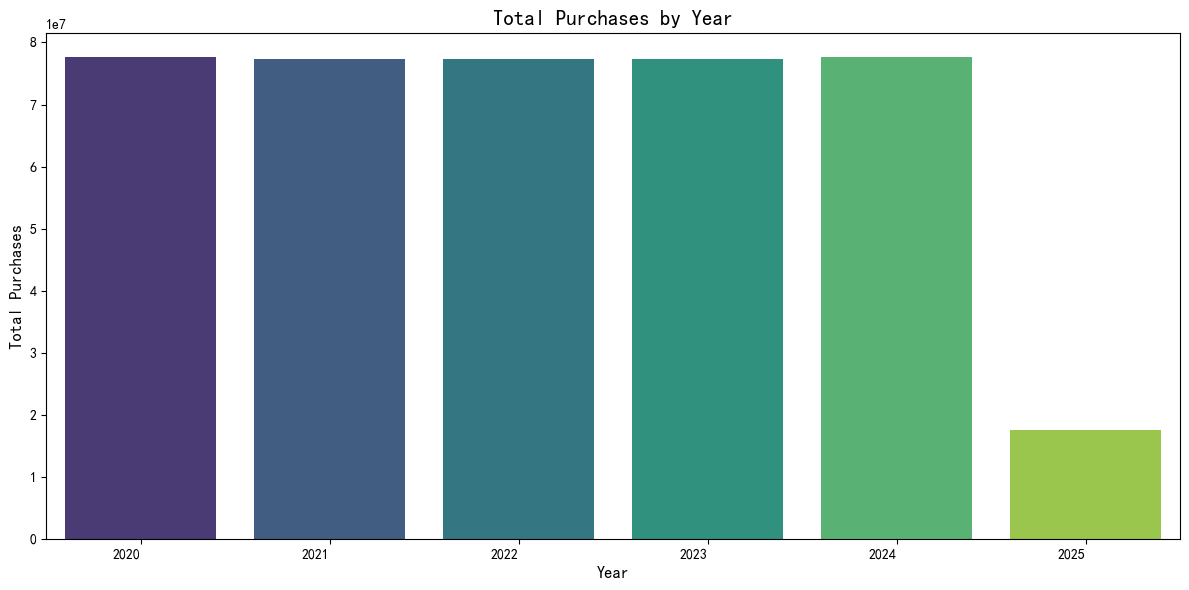

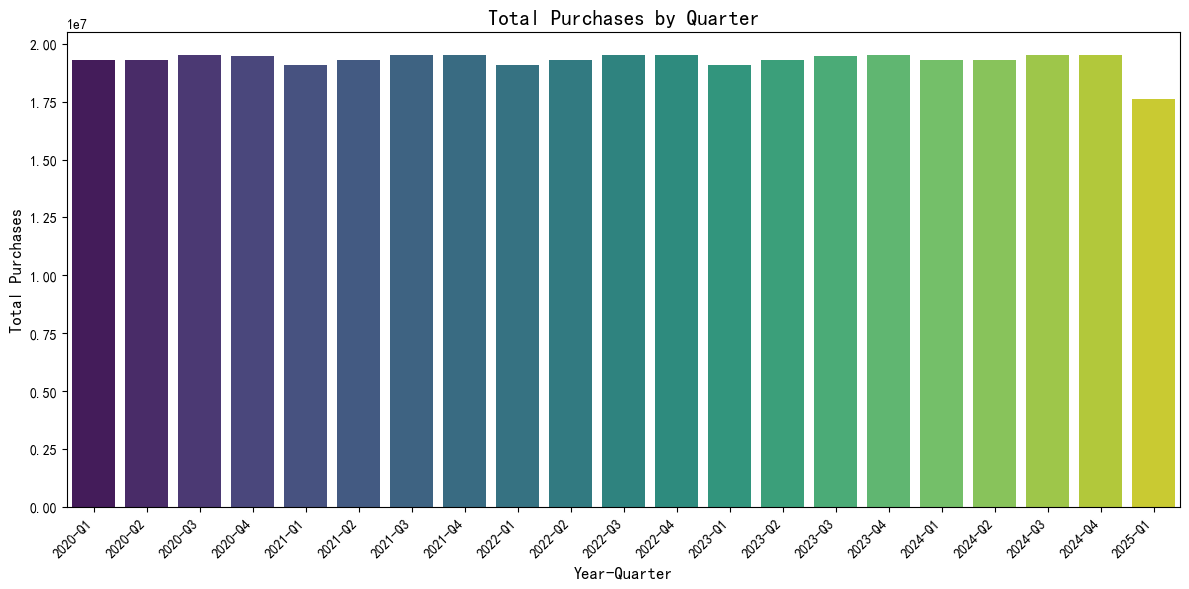

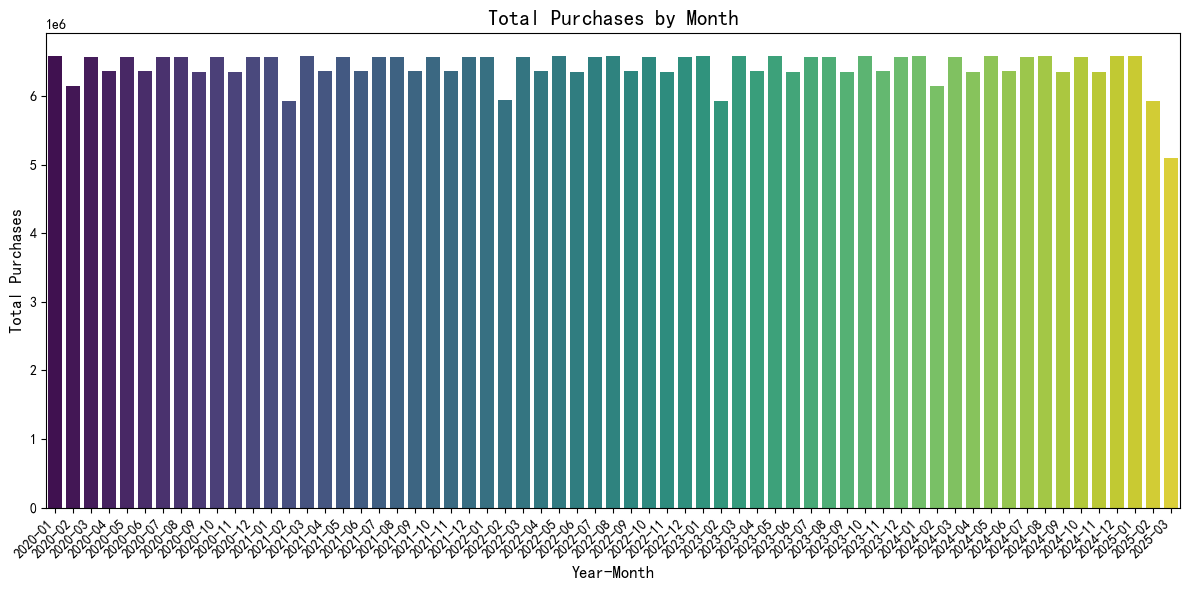

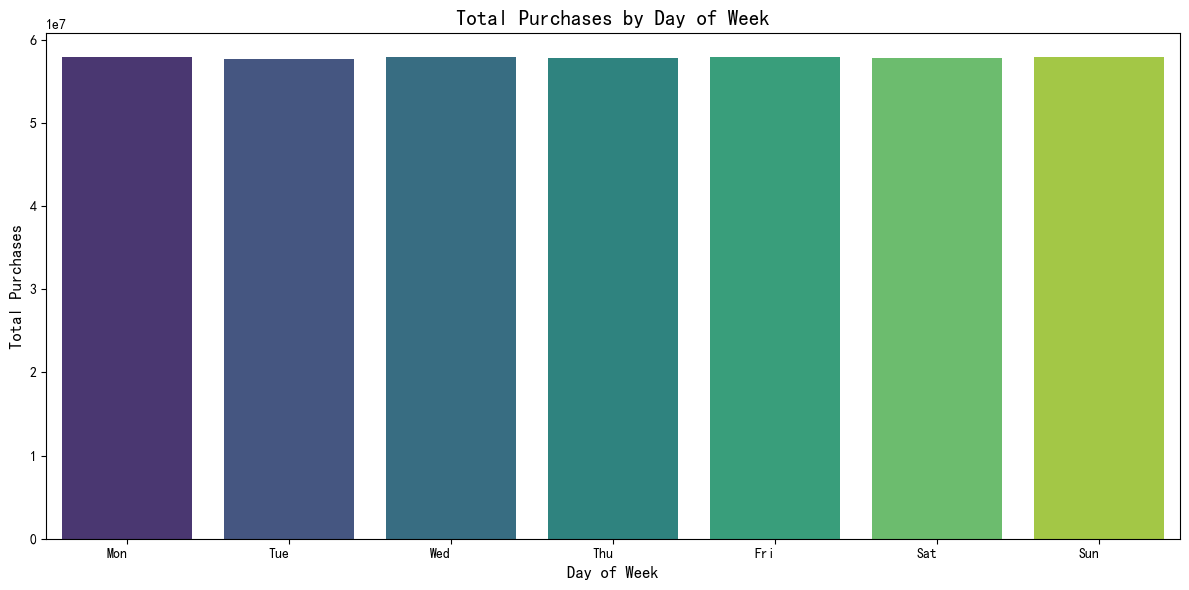


--- Sub-task 3.1 complete ---

--- Sub-task 3.2: Analyzing Purchase Frequency Changes for Major Categories ---
Step 3.2.1: Aggregating purchase counts by (time dimension, major_category)...



Step 3.2.2: Visualizing purchase frequency changes for major categories...



Plotting Monthly Purchase Trends for each Major Category (excluding incomplete 2025)...


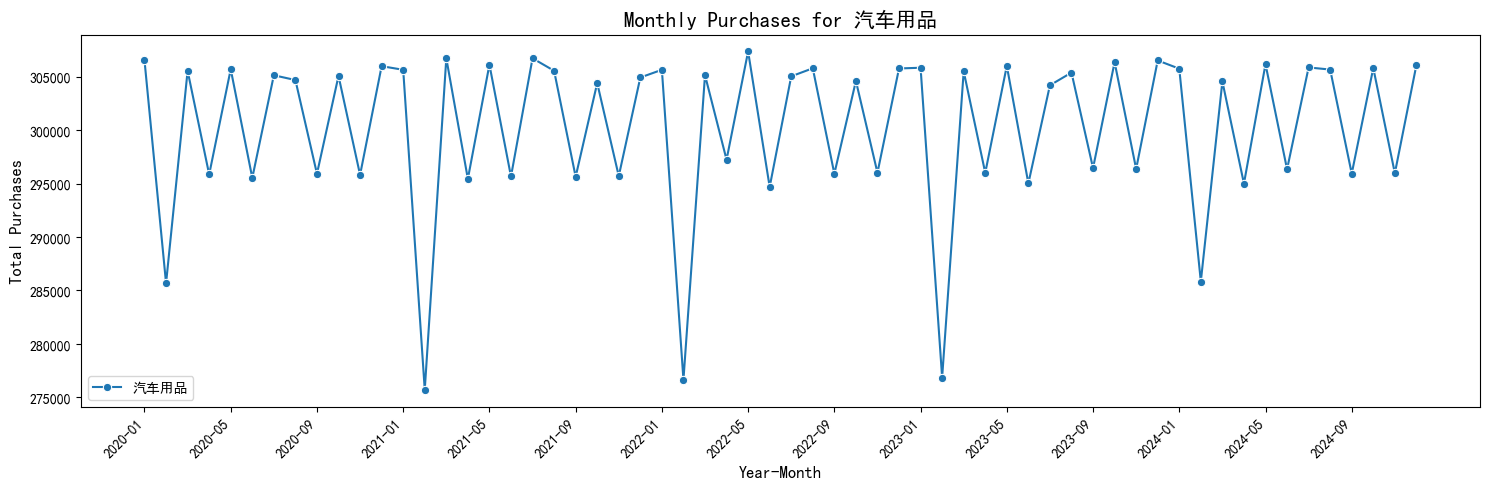

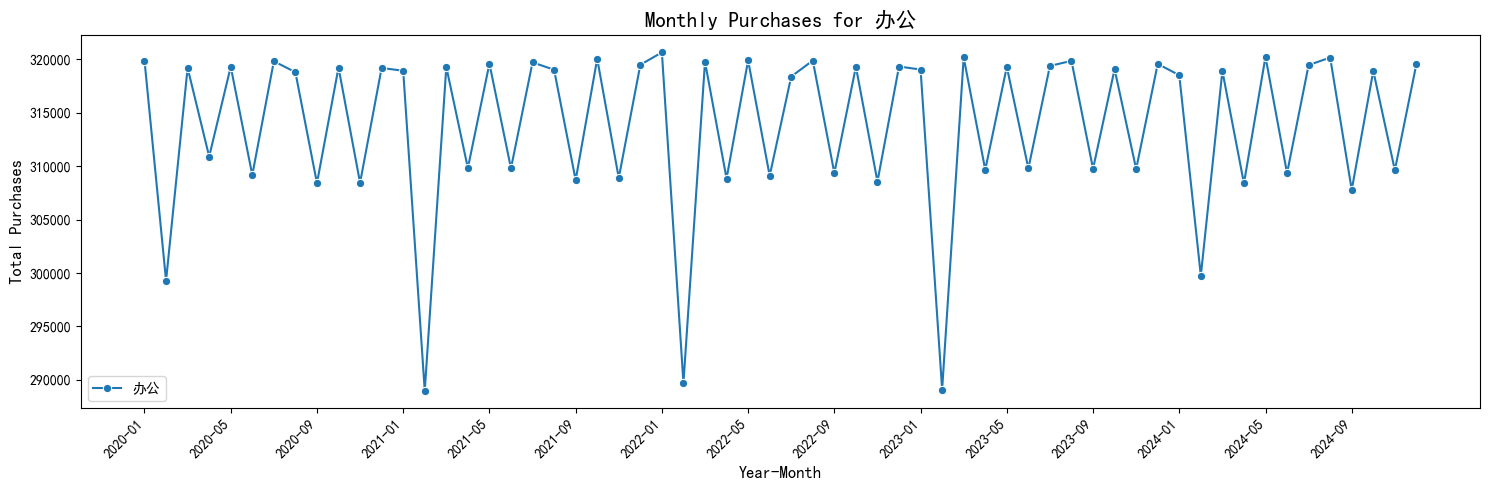

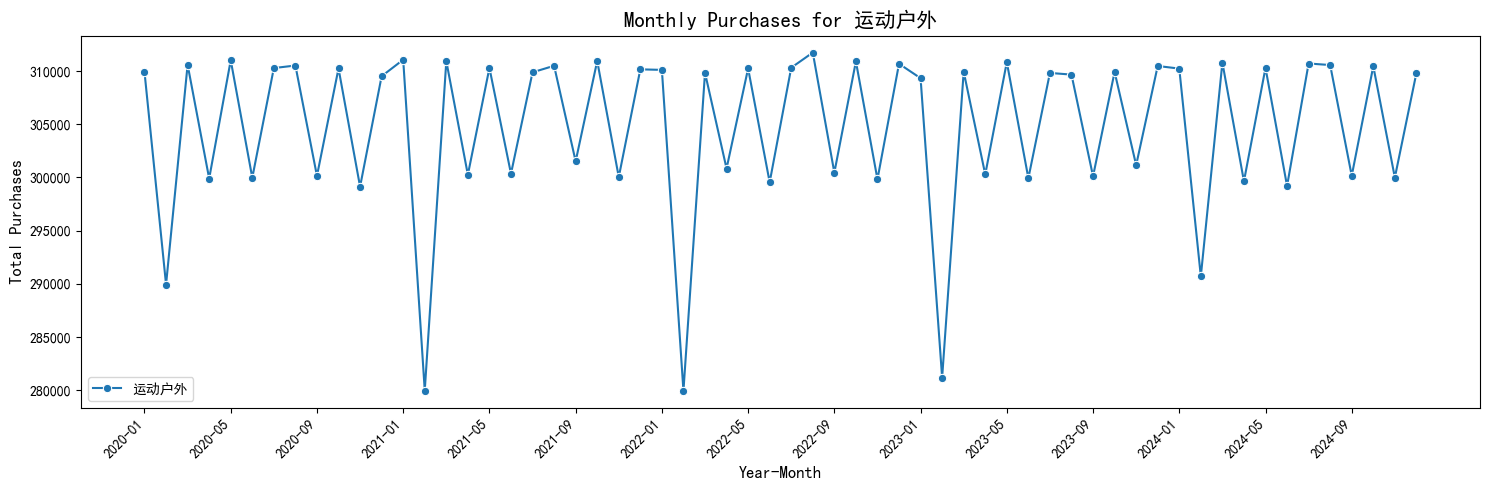

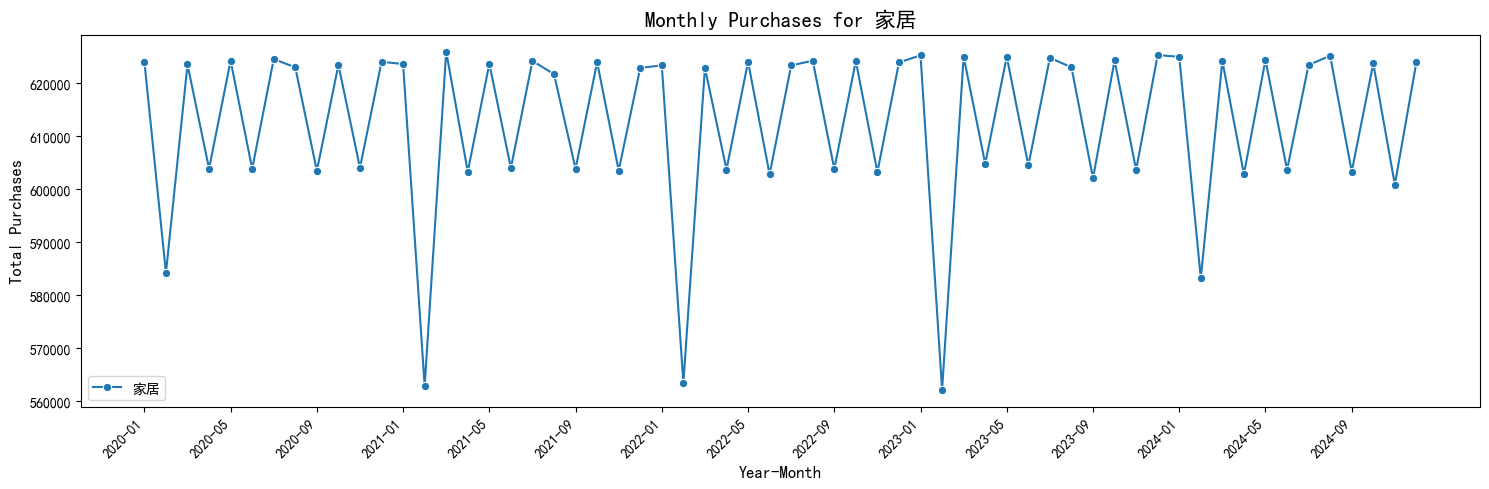

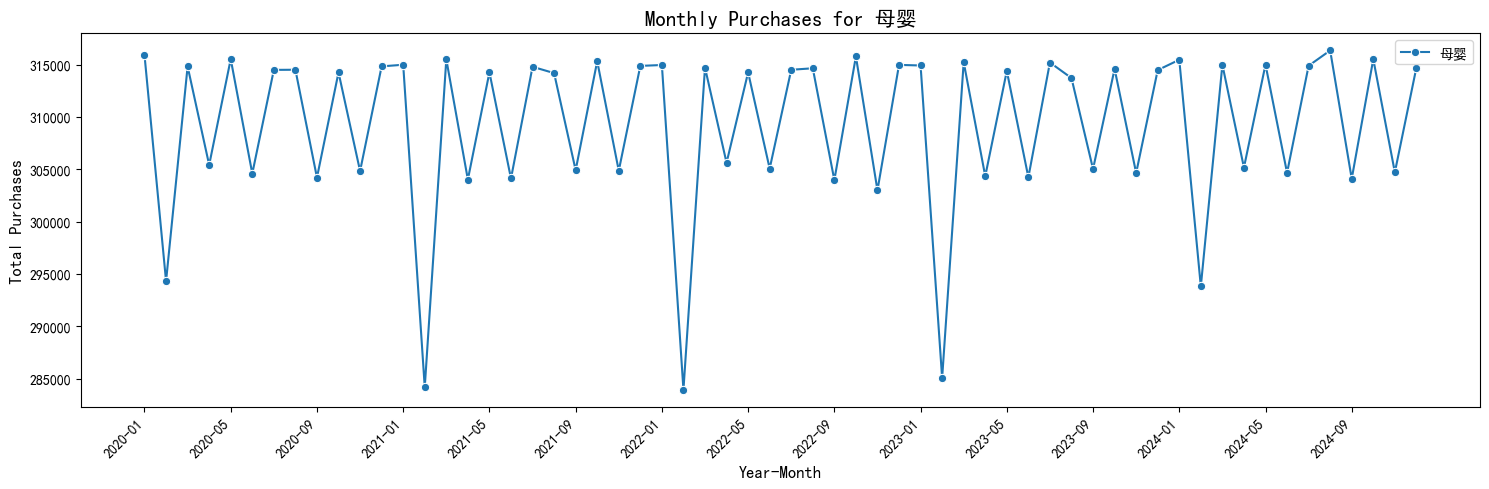

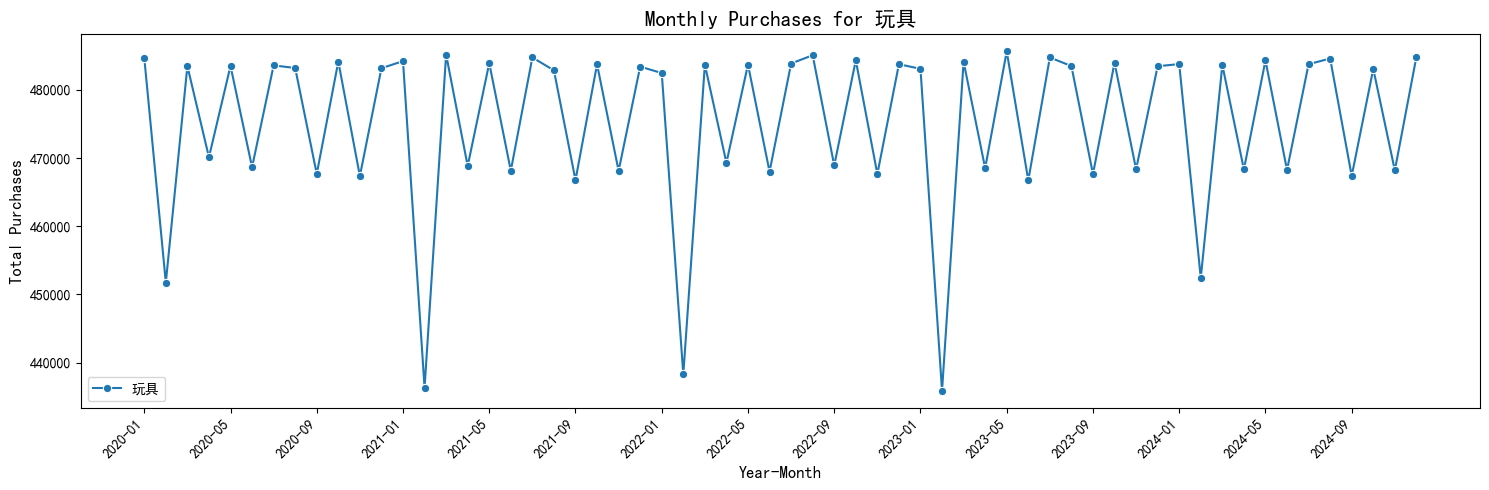

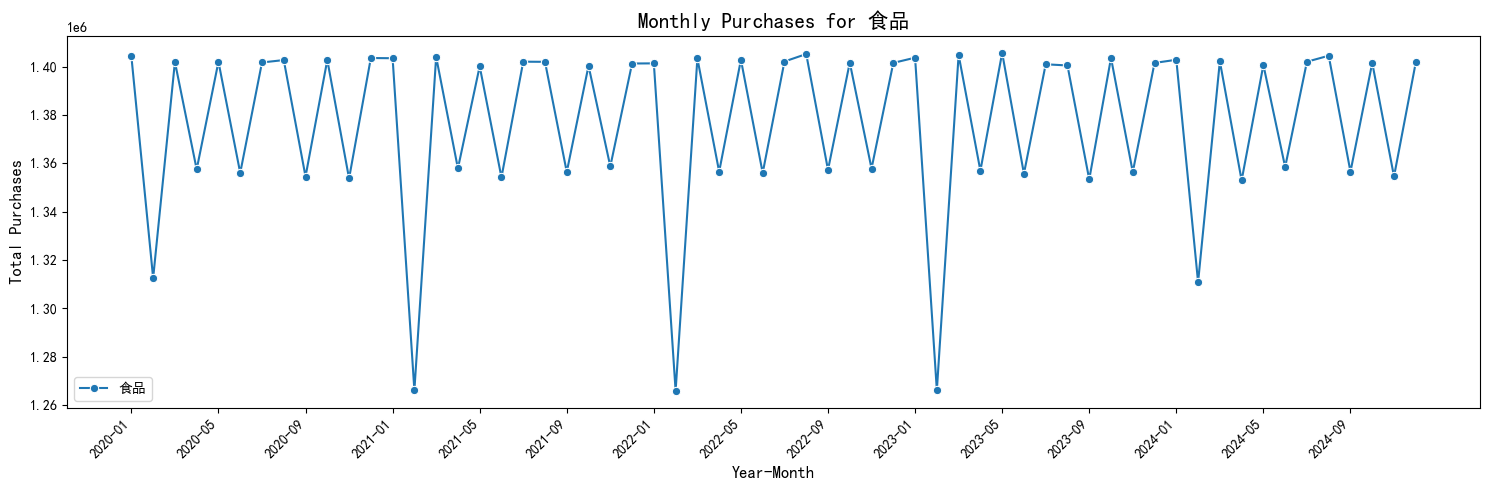

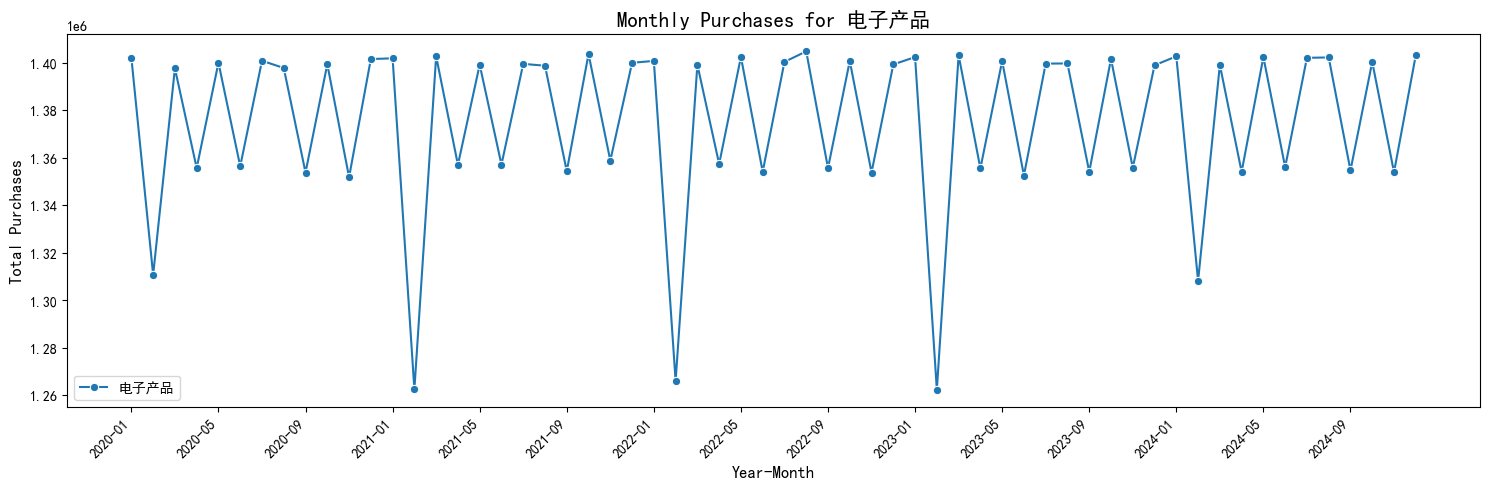

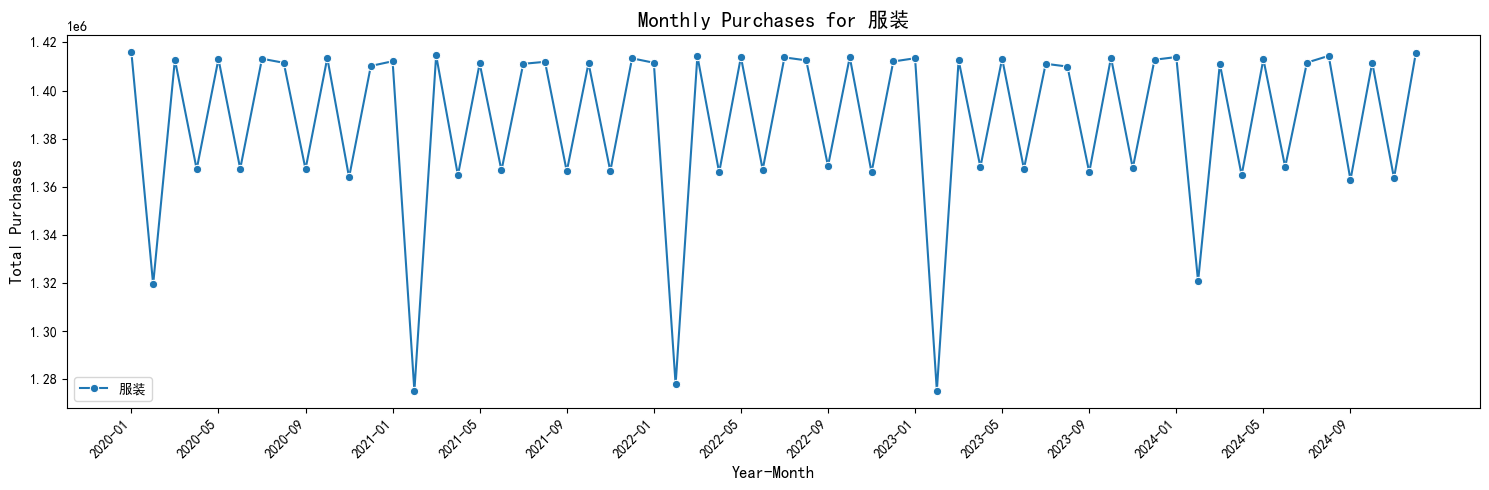


Plotting Quarterly Purchase Trends for each Major Category (excluding incomplete 2025)...


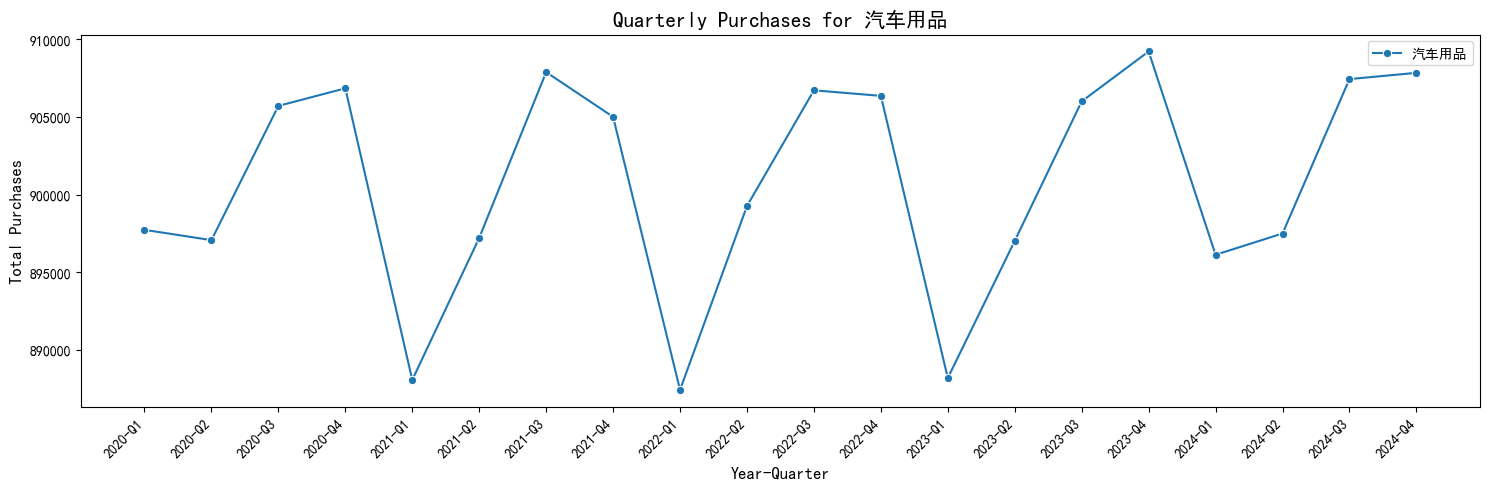

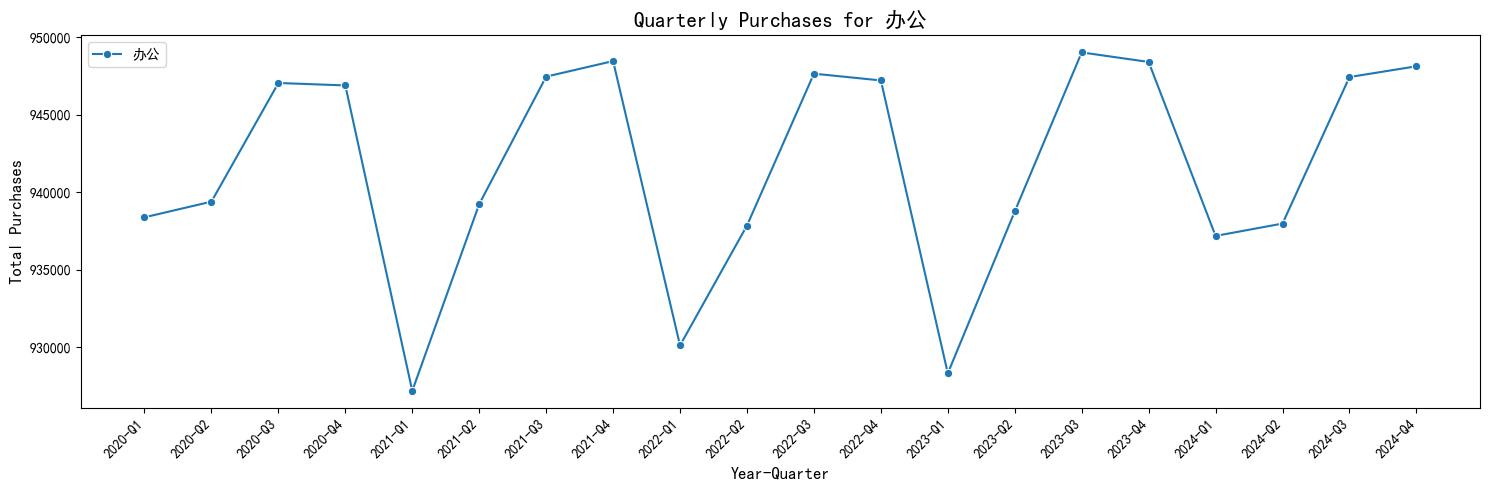

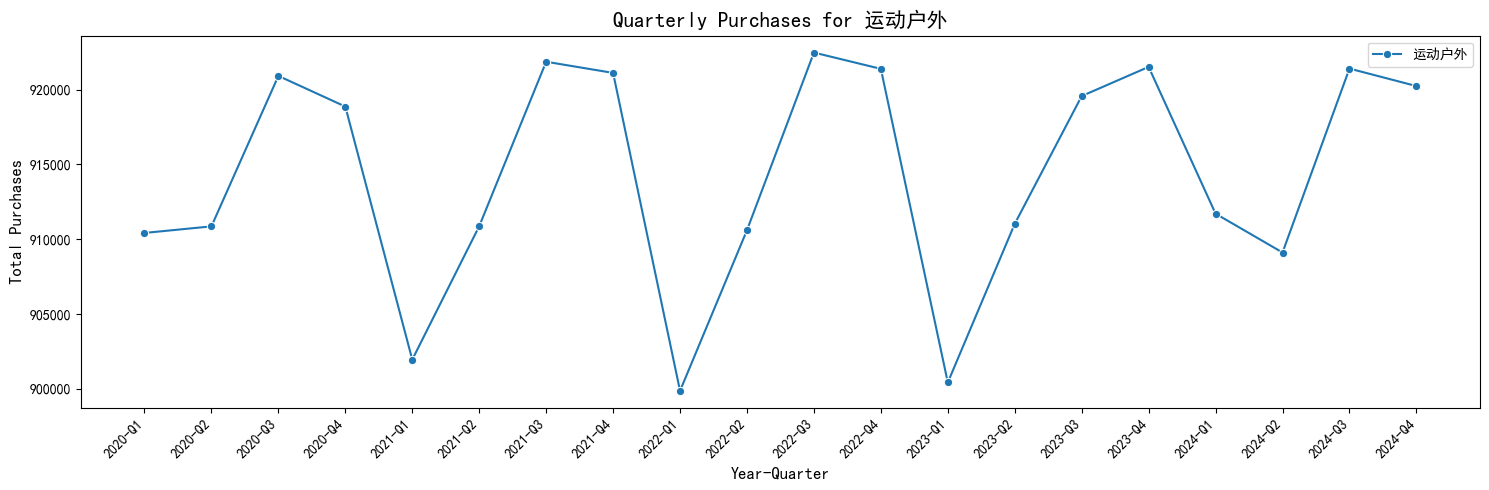

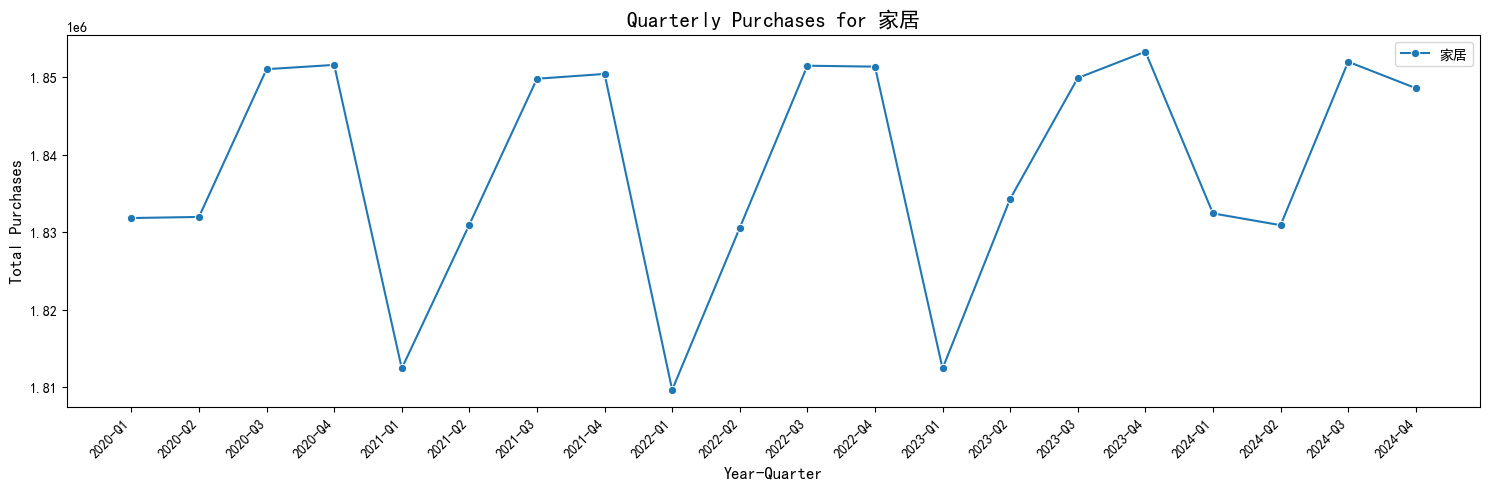

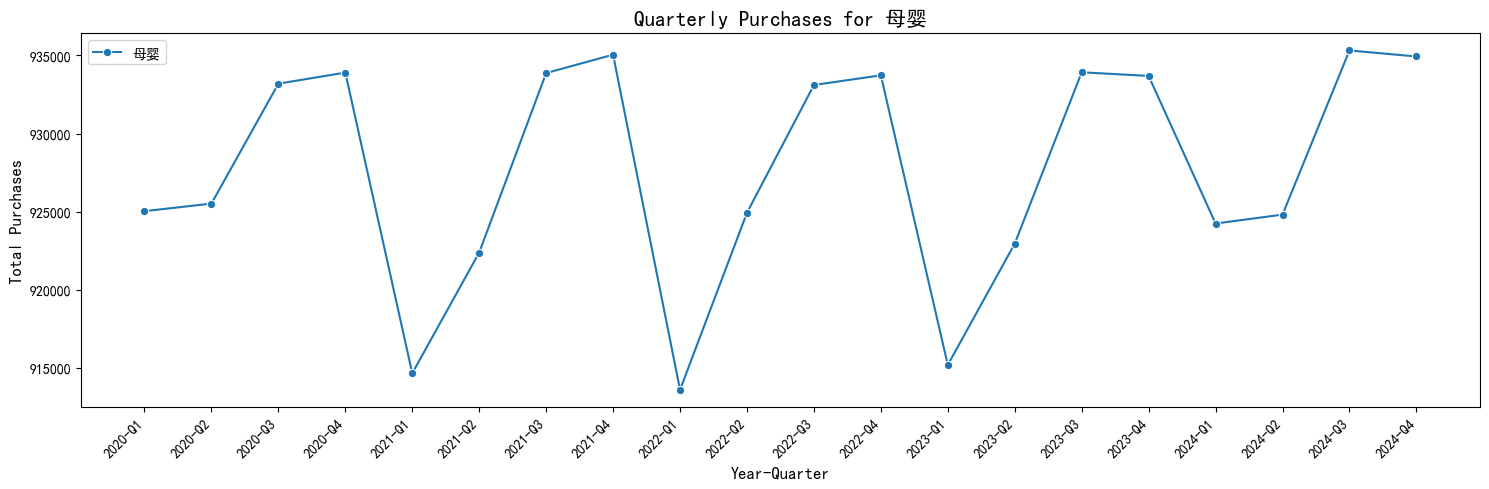

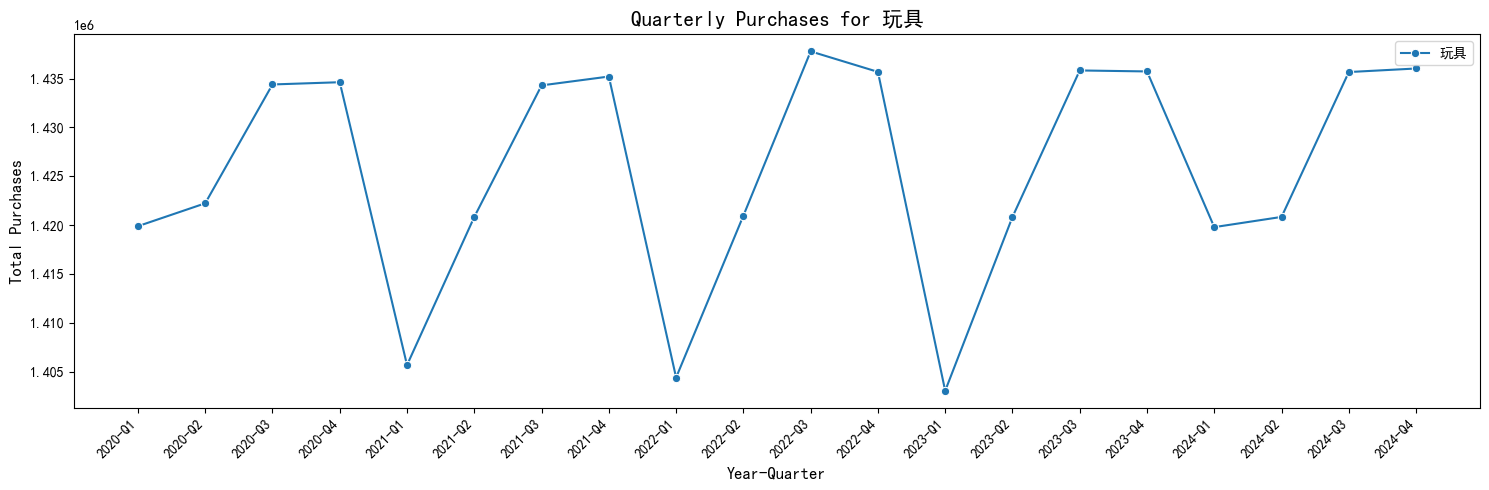

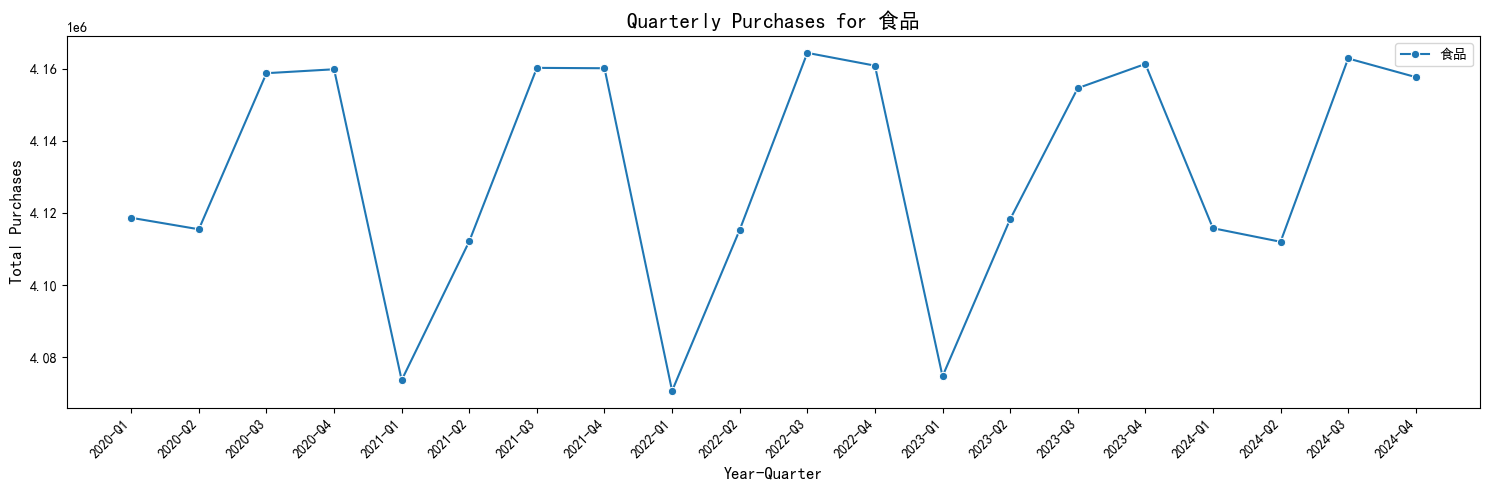

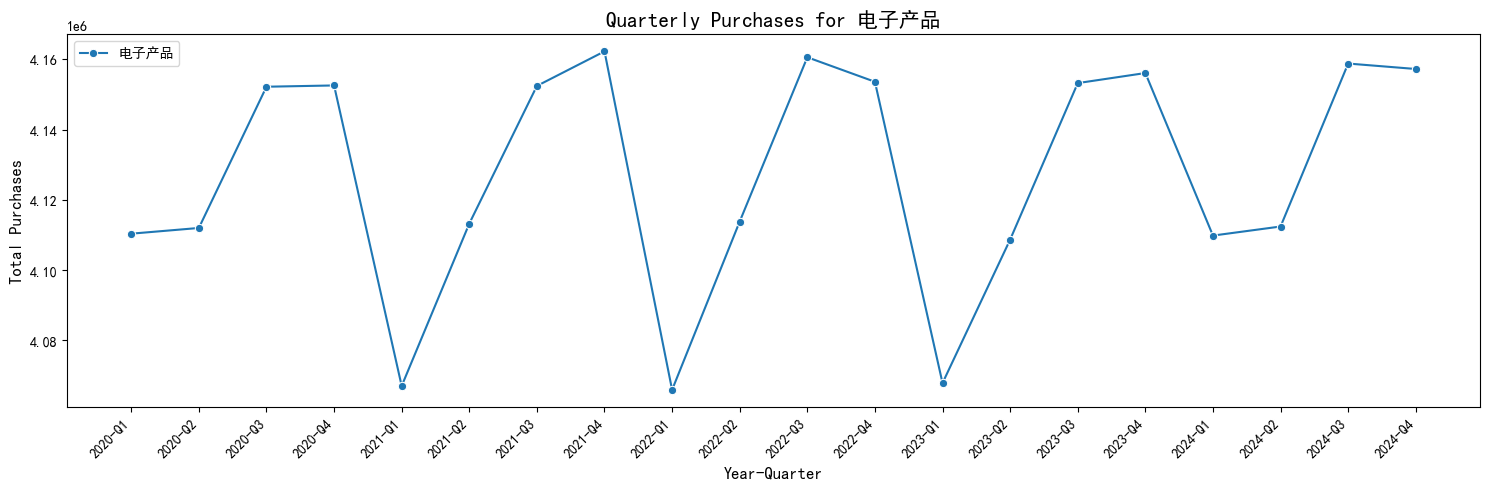

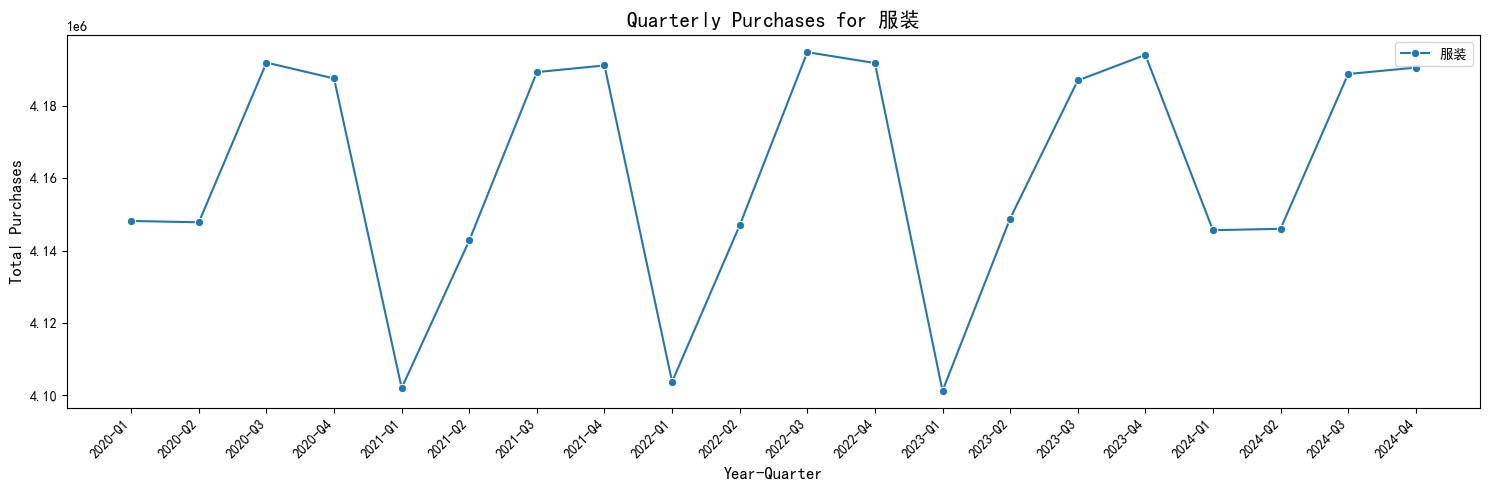


Plotting Day of Week Purchase Distribution for Major Categories...


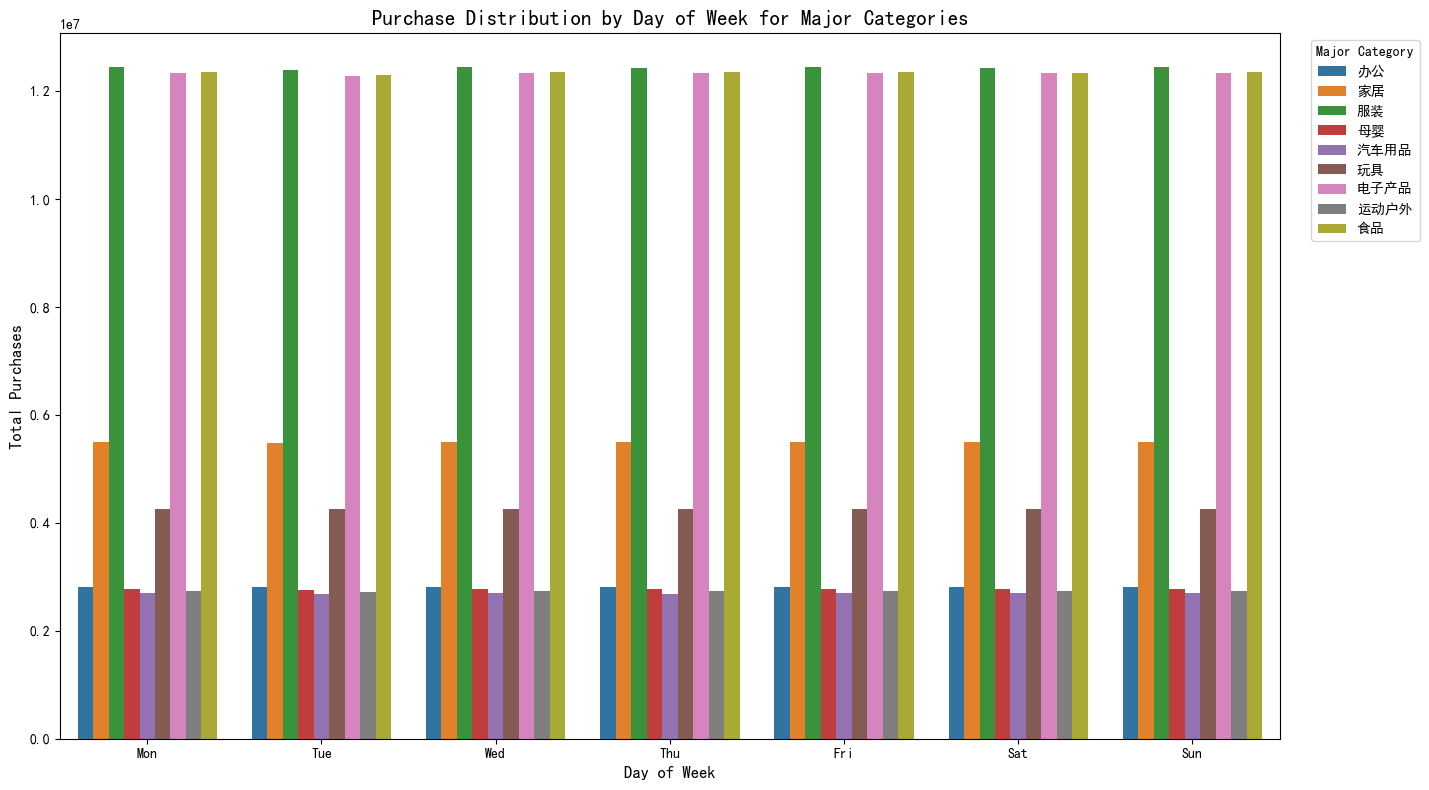


--- Sub-task 3.2 complete ---

--- Sub-task 3.3: Sequential Purchase Patterns (A then B) - OPTIMIZED ---
Step 3.3.1: Building user's ordered transaction list with major categories...

Step 3.3.2: Getting previous transaction's categories for each user...

Sample of (Previous Categories -> Current Categories) pairs (Task 3.3):


+-------+-------------------+------------------+-------------+
|user_id|previous_categories|current_categories|purchase_date|
+-------+-------------------+------------------+-------------+
+-------+-------------------+------------------+-------------+


Step 3.3.3 (Optimized): Analyzing category transitions using explode...

Numerator counts (A item -> B item in consecutive transactions):


+------------+------------+---------------------------------+
|prev_cat_num|curr_cat_num|count_prevA_currB_pair_occurrence|
+------------+------------+---------------------------------+
+------------+------------+---------------------------------+


Denominator counts (Prev item A occurrences):


+------------+-----------+
|prev_cat_den|count_fromA|
+------------+-----------+
+------------+-----------+


Calculating 'sequential confidence' (Optimized - Task 3.3)...

Top Sequential 'Confidence' (Optimized P(Next item B | Prev item A in transactions) - Task 3.3):


+-------------+-----------+---------------+-----------+---------------------+
|from_category|to_category|count_fromA_toB|count_fromA|sequential_confidence|
+-------------+-----------+---------------+-----------+---------------------+
+-------------+-----------+---------------+-----------+---------------------+




Step 3.3.4: Visualizing sequential confidence...


No sequential confidence rules found for Task 3.3.

--- Sub-task 3.3 complete ---
--- TASK 3 Complete ---


In [2]:
# ==============================================================================
# TASK 3: 时间序列模式挖掘
# ==============================================================================
print("\n\n--- TASK 3: Temporal Pattern Mining ---")
print("\n--- Sub-task 3.1: Analyzing Seasonal Shopping Patterns ---")
print("Step 3.1.1: Extracting temporal features from 'purchase_date'...")
temporal_df = df_final_preprocessed.withColumn("purchase_year", year(col("purchase_date"))) \
                                   .withColumn("purchase_quarter", quarter(col("purchase_date"))) \
                                   .withColumn("purchase_month", month(col("purchase_date"))) \
                                   .withColumn("purchase_dayofweek", dayofweek(col("purchase_date"))) \
                                   .withColumn("purchase_weekday_name", date_format(col("purchase_date"), "E")) \
                                   .withColumn("purchase_hour", lit(None).cast("integer")) # No hour info
temporal_df.cache()
temporal_df.select("purchase_date", "purchase_year", "purchase_quarter", "purchase_month", "purchase_dayofweek", "purchase_weekday_name").show(5)
print("\nStep 3.1.2: Aggregating purchase counts by different time dimensions...")
purchases_by_year_task3_1 = temporal_df.groupBy("purchase_year").agg(count("*").alias("total_purchases")).orderBy("purchase_year")
print("\nTotal purchases by Year:"); purchases_by_year_task3_1.show()
purchases_by_year_task3_1.write.mode("overwrite").csv(os.path.join(tables_dir, "task3_1_purchases_by_year.csv"), header=True)
purchases_by_quarter_task3_1 = temporal_df.groupBy("purchase_year", "purchase_quarter").agg(count("*").alias("total_purchases")).orderBy("purchase_year", "purchase_quarter")
print("\nTotal purchases by Quarter:"); purchases_by_quarter_task3_1.show(50) # Show more rows
purchases_by_quarter_task3_1.write.mode("overwrite").csv(os.path.join(tables_dir, "task3_1_purchases_by_quarter.csv"), header=True)
purchases_by_month_task3_1 = temporal_df.groupBy("purchase_year", "purchase_month").agg(count("*").alias("total_purchases")).orderBy("purchase_year", "purchase_month")
print("\nTotal purchases by Month:"); purchases_by_month_task3_1.show(50) # Show more rows
purchases_by_month_task3_1.write.mode("overwrite").csv(os.path.join(tables_dir, "task3_1_purchases_by_month.csv"), header=True)
purchases_by_dayofweek_task3_1 = temporal_df.groupBy("purchase_dayofweek", "purchase_weekday_name").agg(count("*").alias("total_purchases")).orderBy("purchase_dayofweek")
print("\nTotal purchases by Day of Week:"); purchases_by_dayofweek_task3_1.show()
purchases_by_dayofweek_task3_1.write.mode("overwrite").csv(os.path.join(tables_dir, "task3_1_purchases_by_dayofweek.csv"), header=True)
print("\nStep 3.1.3: Visualizing seasonal patterns...")
purchases_by_year_pd_task3_1 = purchases_by_year_task3_1.toPandas()
purchases_by_quarter_pd_task3_1 = purchases_by_quarter_task3_1.toPandas(); purchases_by_quarter_pd_task3_1["year_quarter"] = purchases_by_quarter_pd_task3_1["purchase_year"].astype(str) + "-Q" + purchases_by_quarter_pd_task3_1["purchase_quarter"].astype(str)
purchases_by_month_pd_task3_1 = purchases_by_month_task3_1.toPandas(); purchases_by_month_pd_task3_1["year_month"] = purchases_by_month_pd_task3_1["purchase_year"].astype(str) + "-" + purchases_by_month_pd_task3_1["purchase_month"].astype(str).str.zfill(2)
purchases_by_dayofweek_pd_task3_1 = purchases_by_dayofweek_task3_1.toPandas()
def plot_temporal_distribution_task3(df_pd, x_col, y_col, title, xlabel, filename, ylabel="Total Purchases", sort_x=False, rotation=45):
    if df_pd.empty: print(f"No data to plot for {title}"); return
    if sort_x: df_pd = df_pd.sort_values(by=x_col)
    plt.figure(figsize=(12, 6)); sns.barplot(x=x_col, y=y_col, data=df_pd, palette="viridis")
    plt.title(title, fontsize=15); plt.xlabel(xlabel, fontsize=12); plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=rotation, ha="right"); plt.tight_layout(); plt.savefig(filename); plt.show()
if not purchases_by_year_pd_task3_1.empty: plot_temporal_distribution_task3(purchases_by_year_pd_task3_1, "purchase_year", "total_purchases", "Total Purchases by Year", "Year", os.path.join(charts_dir,"task3_1_year.png"), rotation=0)
if not purchases_by_quarter_pd_task3_1.empty: plot_temporal_distribution_task3(purchases_by_quarter_pd_task3_1, "year_quarter", "total_purchases", "Total Purchases by Quarter", "Year-Quarter", os.path.join(charts_dir,"task3_1_quarter.png"))
if not purchases_by_month_pd_task3_1.empty: plot_temporal_distribution_task3(purchases_by_month_pd_task3_1, "year_month", "total_purchases", "Total Purchases by Month", "Year-Month", os.path.join(charts_dir,"task3_1_month.png"))
if not purchases_by_dayofweek_pd_task3_1.empty:
    weekday_order_task3 = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
    try: purchases_by_dayofweek_pd_task3_1['purchase_weekday_name'] = pd.Categorical(purchases_by_dayofweek_pd_task3_1['purchase_weekday_name'], categories=weekday_order_task3, ordered=True); purchases_by_dayofweek_pd_task3_1 = purchases_by_dayofweek_pd_task3_1.sort_values('purchase_weekday_name')
    except Exception as e: print(f"Could not reorder weekday names for Task 3.1: {e}")
    plot_temporal_distribution_task3(purchases_by_dayofweek_pd_task3_1, "purchase_weekday_name", "total_purchases", "Total Purchases by Day of Week", "Day of Week", os.path.join(charts_dir,"task3_1_dayofweek.png"), rotation=0)
print("\n--- Sub-task 3.1 complete ---")

print("\n--- Sub-task 3.2: Analyzing Purchase Frequency Changes for Major Categories ---")
print("Step 3.2.1: Aggregating purchase counts by (time dimension, major_category)...")
purchases_by_month_category_task3_2 = temporal_df.groupBy("purchase_year", "purchase_month", "item_major_category").agg(count("*").alias("total_purchases")).orderBy("purchase_year", "purchase_month", "item_major_category")
purchases_by_month_category_task3_2.write.mode("overwrite").parquet(os.path.join(tables_dir, "task3_2_month_category.parquet"))
purchases_by_quarter_category_task3_2 = temporal_df.groupBy("purchase_year", "purchase_quarter", "item_major_category").agg(count("*").alias("total_purchases")).orderBy("purchase_year", "purchase_quarter", "item_major_category")
purchases_by_quarter_category_task3_2.write.mode("overwrite").parquet(os.path.join(tables_dir, "task3_2_quarter_category.parquet"))
purchases_by_dayofweek_category_task3_2 = temporal_df.groupBy("purchase_dayofweek", "purchase_weekday_name", "item_major_category").agg(count("*").alias("total_purchases")).orderBy("purchase_dayofweek", "item_major_category")
purchases_by_dayofweek_category_task3_2.write.mode("overwrite").parquet(os.path.join(tables_dir, "task3_2_dayofweek_category.parquet"))
print("\nStep 3.2.2: Visualizing purchase frequency changes for major categories...")
major_categories_task3_2 = [row.item_major_category for row in temporal_df.select("item_major_category").distinct().collect()]
purchases_by_month_category_pd_task3_2 = purchases_by_month_category_task3_2.toPandas(); purchases_by_month_category_pd_task3_2["year_month"] = purchases_by_month_category_pd_task3_2["purchase_year"].astype(str) + "-" + purchases_by_month_category_pd_task3_2["purchase_month"].astype(str).str.zfill(2)
purchases_by_quarter_category_pd_task3_2 = purchases_by_quarter_category_task3_2.toPandas(); purchases_by_quarter_category_pd_task3_2["year_quarter"] = purchases_by_quarter_category_pd_task3_2["purchase_year"].astype(str) + "-Q" + purchases_by_quarter_category_pd_task3_2["purchase_quarter"].astype(str)
purchases_by_dayofweek_category_pd_task3_2 = purchases_by_dayofweek_category_task3_2.toPandas()
def plot_category_temporal_task3_2(df_pd, category, time_col, value_col, title_prefix, xlabel, filename, rotation=45):
    category_data = df_pd[df_pd["item_major_category"] == category];
    if category_data.empty: print(f"No data for {category} in {title_prefix}"); return
    category_data = category_data.sort_values(by=time_col)
    plt.figure(figsize=(15, 5)); sns.lineplot(x=time_col, y=value_col, data=category_data, marker='o', label=category)
    plt.title(f"{title_prefix} for {category}", fontsize=15); plt.xlabel(xlabel, fontsize=12); plt.ylabel("Total Purchases", fontsize=12); plt.xticks(rotation=rotation, ha="right")
    if len(category_data[time_col].unique()) > 20: tick_spacing = max(1, len(category_data[time_col].unique()) // 15); plt.xticks(category_data[time_col].unique()[::tick_spacing])
    plt.legend(); plt.tight_layout(); plt.savefig(filename); plt.show()
print("\nPlotting Monthly Purchase Trends for each Major Category (excluding incomplete 2025)...")
purchases_by_month_category_pd_filtered_task3_2 = purchases_by_month_category_pd_task3_2[purchases_by_month_category_pd_task3_2["purchase_year"] < 2025]
for category_task3_2 in major_categories_task3_2: plot_category_temporal_task3_2(purchases_by_month_category_pd_filtered_task3_2, category_task3_2, "year_month", "total_purchases", "Monthly Purchases", "Year-Month", os.path.join(charts_dir, f"task3_2_monthly_{category_task3_2.replace('/', '_')}.png"))
print("\nPlotting Quarterly Purchase Trends for each Major Category (excluding incomplete 2025)...")
purchases_by_quarter_category_pd_filtered_task3_2 = purchases_by_quarter_category_pd_task3_2[purchases_by_quarter_category_pd_task3_2["purchase_year"] < 2025]
for category_task3_2 in major_categories_task3_2: plot_category_temporal_task3_2(purchases_by_quarter_category_pd_filtered_task3_2, category_task3_2, "year_quarter", "total_purchases", "Quarterly Purchases", "Year-Quarter", os.path.join(charts_dir, f"task3_2_quarterly_{category_task3_2.replace('/', '_')}.png"))
print("\nPlotting Day of Week Purchase Distribution for Major Categories...")
if not purchases_by_dayofweek_category_pd_task3_2.empty:
    plt.figure(figsize=(16, 8))
    try: purchases_by_dayofweek_category_pd_task3_2['purchase_weekday_name'] = pd.Categorical(purchases_by_dayofweek_category_pd_task3_2['purchase_weekday_name'], categories=weekday_order_task3, ordered=True); purchases_by_dayofweek_category_pd_task3_2 = purchases_by_dayofweek_category_pd_task3_2.sort_values(['item_major_category', 'purchase_weekday_name'])
    except Exception as e: print(f"Could not reorder weekday names for Task 3.2: {e}")
    sns.barplot(x="purchase_weekday_name", y="total_purchases", hue="item_major_category", data=purchases_by_dayofweek_category_pd_task3_2, palette="tab10")
    plt.title("Purchase Distribution by Day of Week for Major Categories", fontsize=15); plt.xlabel("Day of Week", fontsize=12); plt.ylabel("Total Purchases", fontsize=12); plt.xticks(rotation=0); plt.legend(title="Major Category", bbox_to_anchor=(1.02, 1), loc='upper left'); plt.tight_layout(rect=[0, 0, 0.9, 1]); plt.savefig(os.path.join(charts_dir,"task3_2_dayofweek_all_categories.png")); plt.show()
else: print("No data for day of week by category to plot (Task 3.2).")
temporal_df.unpersist() # Unpersist temporal_df
print("\n--- Sub-task 3.2 complete ---")

print("\n--- Sub-task 3.3: Sequential Purchase Patterns (A then B) - OPTIMIZED ---")
print("Step 3.3.1: Building user's ordered transaction list with major categories...") # Assuming major categories for this part
user_transactions_df_task3_3 = df_final_preprocessed.groupBy(
    "user_id", "purchase_date", "payment_method", "payment_status", "transaction_avg_price"
).agg(collect_set("item_major_category").alias("current_categories")) \
 .orderBy("user_id", "purchase_date", "payment_method", "payment_status", "transaction_avg_price")

print("\nStep 3.3.2: Getting previous transaction's categories for each user...")
window_spec_user_time_task3_3 = PySparkWindow.partitionBy("user_id").orderBy(
    "purchase_date", "payment_method", "payment_status", "transaction_avg_price"
)
transactions_with_lag_df_task3_3 = user_transactions_df_task3_3.withColumn(
    "previous_categories",
    lag("current_categories", 1).over(window_spec_user_time_task3_3)
)
sequential_pairs_df_task3_3 = transactions_with_lag_df_task3_3 \
    .where(col("previous_categories").isNotNull()) \
    .select("user_id", "previous_categories", "current_categories", "purchase_date").cache()
print("\nSample of (Previous Categories -> Current Categories) pairs (Task 3.3):")
sequential_pairs_df_task3_3.show(5, truncate=False)

print("\nStep 3.3.3 (Optimized): Analyzing category transitions using explode...")
# 分子: Count(PrevTxHasA and CurrTxHasB for specific A and B items)
numerator_df_optimized_task3_3 = sequential_pairs_df_task3_3 \
    .select(explode(col("previous_categories")).alias("prev_cat_num"), 
            explode(col("current_categories")).alias("curr_cat_num")) \
    .where(col("prev_cat_num") != col("curr_cat_num")) \
    .groupBy("prev_cat_num", "curr_cat_num") \
    .agg(count("*").alias("count_prevA_currB_pair_occurrence"))

print("\nNumerator counts (A item -> B item in consecutive transactions):")
numerator_df_optimized_task3_3.orderBy(desc("count_prevA_currB_pair_occurrence")).show(10, truncate=False)


# 分母: Count(PrevTxHasA occurrence in any previous_categories of valid pairs)
denominator_df_optimized_task3_3 = sequential_pairs_df_task3_3 \
    .select(explode(col("previous_categories")).alias("prev_cat_den")) \
    .groupBy("prev_cat_den") \
    .agg(count("*").alias("count_fromA")) # Renamed here to be final column name for denominator

print("\nDenominator counts (Prev item A occurrences):")
denominator_df_optimized_task3_3.orderBy(desc("count_fromA")).show(10, truncate=False)


print("\nCalculating 'sequential confidence' (Optimized - Task 3.3)...")
seq_confidence_df_task3_3 = numerator_df_optimized_task3_3.join(
    denominator_df_optimized_task3_3,
    numerator_df_optimized_task3_3["prev_cat_num"] == denominator_df_optimized_task3_3["prev_cat_den"],
    "inner" # Explicit join type
).withColumn(
    "sequential_confidence",
    col("count_prevA_currB_pair_occurrence") / col("count_fromA")
).select(
    col("prev_cat_num").alias("from_category"),
    col("curr_cat_num").alias("to_category"),
    col("count_prevA_currB_pair_occurrence").alias("count_fromA_toB"),
    col("count_fromA"),
    "sequential_confidence"
).orderBy(desc("sequential_confidence"))

print("\nTop Sequential 'Confidence' (Optimized P(Next item B | Prev item A in transactions) - Task 3.3):")
seq_confidence_df_task3_3.show(20, truncate=False)
seq_confidence_df_task3_3.write.mode("overwrite").csv(os.path.join(tables_dir, "task3_3_sequential_confidence.csv"), header=True)

print("\nStep 3.3.4: Visualizing sequential confidence...")
if seq_confidence_df_task3_3.count() > 0: 
    seq_confidence_pd_task3_3 = seq_confidence_df_task3_3.limit(100).toPandas() 
    if not seq_confidence_pd_task3_3.empty:
        try:
            # Attempt to create a reasonable pivot for heatmap, might be sparse
            # Consider taking top N from_category and to_category for a denser heatmap
            top_from_cats = seq_confidence_pd_task3_3.nlargest(15, 'count_fromA')['from_category'].unique()
            top_to_cats = seq_confidence_pd_task3_3.nlargest(15, 'count_fromA_toB')['to_category'].unique()
            
            heatmap_data_filtered = seq_confidence_pd_task3_3[
                seq_confidence_pd_task3_3['from_category'].isin(top_from_cats) &
                seq_confidence_pd_task3_3['to_category'].isin(top_to_cats)
            ]

            if not heatmap_data_filtered.empty:
                pivot_df_task3_3 = heatmap_data_filtered.pivot_table(
                    index="from_category", columns="to_category", values="sequential_confidence", fill_value=0
                )
                if not pivot_df_task3_3.empty: # Check if pivot is not empty
                    plt.figure(figsize=(max(10, len(pivot_df_task3_3.columns)*0.8), max(8, len(pivot_df_task3_3.index)*0.6))) # Dynamic size
                    sns.heatmap(pivot_df_task3_3, annot=True, fmt=".3f", cmap="YlGnBu", linewidths=.5, cbar_kws={'label': 'Sequential Confidence'})
                    plt.title("Heatmap of Sequential Confidence (Prev Item A -> Next Item B)"); plt.ylabel("From Category (Previous Transaction)"); plt.xlabel("To Category (Next Transaction)"); plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0); plt.tight_layout(); plt.savefig(os.path.join(charts_dir,"task3_3_seq_confidence_heatmap.png")); plt.show()
                else:
                    print("Pivot table for heatmap is empty after filtering top categories.")
            else:
                print("No data for heatmap after filtering top categories.")

        except Exception as e:
            print(f"Could not generate heatmap for Task 3.3: {e}")
            plt.figure(figsize=(14, 10)); top_n_seq_rules_task3_3 = seq_confidence_pd_task3_3.sort_values(by="sequential_confidence", ascending=False).head(25); top_n_seq_rules_task3_3["rule_str"] = top_n_seq_rules_task3_3["from_category"] + " -> " + top_n_seq_rules_task3_3["to_category"]
            sns.barplot(x="sequential_confidence", y="rule_str", data=top_n_seq_rules_task3_3, palette="coolwarm")
            plt.title("Top 25 Sequential 'Confidence' Rules (Prev Item A -> Next Item B)"); plt.xlabel("Sequential Confidence"); plt.ylabel("Category Transition"); plt.tight_layout(); plt.savefig(os.path.join(charts_dir,"task3_3_seq_confidence_barplot.png")); plt.show()
    else: print("No sequential confidence data to plot for Task 3.3 (Pandas DataFrame is empty).")
else: print("No sequential confidence rules found for Task 3.3.")
sequential_pairs_df_task3_3.unpersist()
print("\n--- Sub-task 3.3 complete ---")
print("--- TASK 3 Complete ---")



--- TASK 4: Refund Pattern Analysis ---

Step 4.1: Filtering transactions with '已退款' or '部分退款' status...


Number of distinct rows in df_final_preprocessed related to refund statuses for grouping: 219881995

Step 4.2: Building item baskets for refund-related transactions...


Total refund transactions (with >= 2 distinct major categories) for FPGrowth (Task 4): 68410975
+---------------------------+
|items_in_refund_transaction|
+---------------------------+
|[食品, 家居, 电子产品]     |
|[服装, 母婴, 食品]         |
|[汽车用品, 运动户外, 食品] |
|[母婴, 食品, 家居]         |
|[服装, 食品, 电子产品]     |
+---------------------------+
only showing top 5 rows


Step 4.3: Running FPGrowth on refund transactions (minSupport=0.005, minConfidence=0.4)...


25/05/20 16:48:58 WARN FPGrowth: Input data is not cached.                      



Step 4.4: Extracting frequent itemsets and association rules from refund transactions...

Frequent Itemsets in Refund Transactions (Task 4):


+----------------------+--------+-----------------------------+
|items                 |freq    |support_percentage_in_refunds|
+----------------------+--------+-----------------------------+
|[服装]                |38922690|56.895                       |
|[食品]                |38739120|56.627                       |
|[电子产品]            |38707120|56.58                        |
|[家居]                |20712716|30.277                       |
|[食品, 服装]          |20033717|29.284                       |
|[电子产品, 服装]      |20016660|29.259                       |
|[电子产品, 食品]      |19910854|29.105                       |
|[玩具]                |16597432|24.261                       |
|[办公]                |11384427|16.641                       |
|[母婴]                |11228615|16.413                       |
|[运动户外]            |11078385|16.194                       |
|[汽车用品]            |10923845|15.968                       |
|[家居, 服装]          |10275593|15.02                        |
|[家居, 食品]          |

Task 4 Refund Frequent Itemsets saved to CSV at: data_mining_results/tables/task4_refund_freq_itemsets.csv

Association Rules from Refund Transactions (Task 4):


+----------------+----------+----------+--------------------------+------------------+---------------+
|rule_str_display|antecedent|consequent|support_percent_in_refunds|confidence_percent|lift_in_refunds|
+----------------+----------+----------+--------------------------+------------------+---------------+
|食品 => 服装    |[食品]    |[服装]    |29.284                    |51.71             |0.91           |
|电子产品 => 服装|[电子产品]|[服装]    |29.259                    |51.71             |0.91           |
|服装 => 食品    |[服装]    |[食品]    |29.284                    |51.47             |0.91           |
|电子产品 => 食品|[电子产品]|[食品]    |29.105                    |51.44             |0.91           |
|服装 => 电子产品|[服装]    |[电子产品]|29.259                    |51.43             |0.91           |
|食品 => 电子产品|[食品]    |[电子产品]|29.105                    |51.4              |0.91           |
|家居 => 服装    |[家居]    |[服装]    |15.02                     |49.61             |0.87           |
|家居 => 食品    |[家居]    |[食品]    |14.941    

Task 4 Refund Association Rules saved to CSV at: data_mining_results/tables/task4_refund_rules.csv


Total association rules found from refund transactions (Task 4): 108

Step 4.5: Visualizing refund-related association rules...


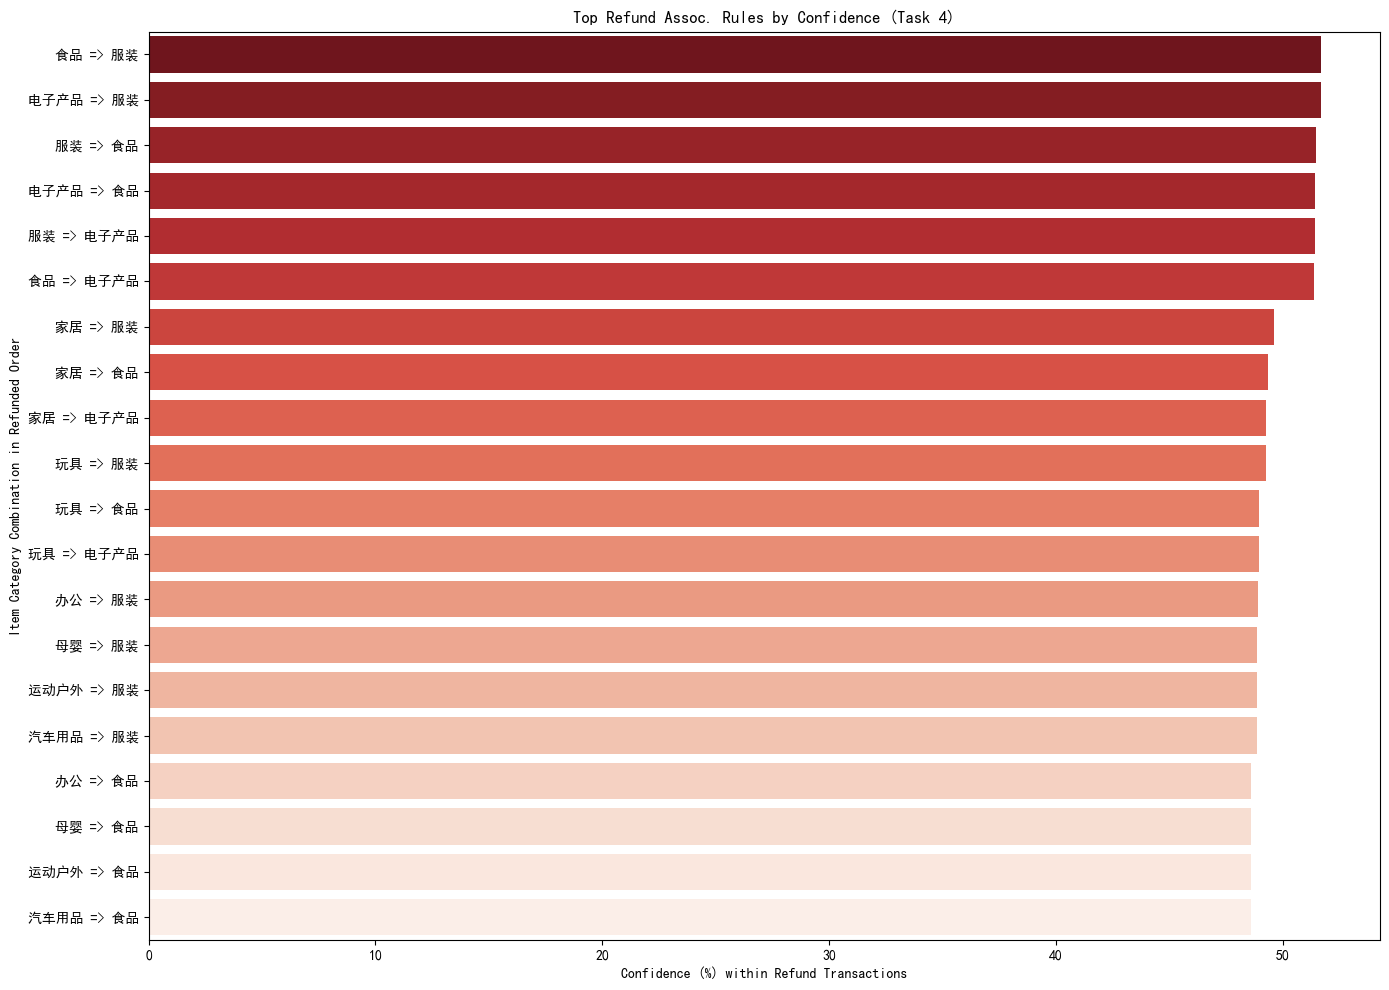

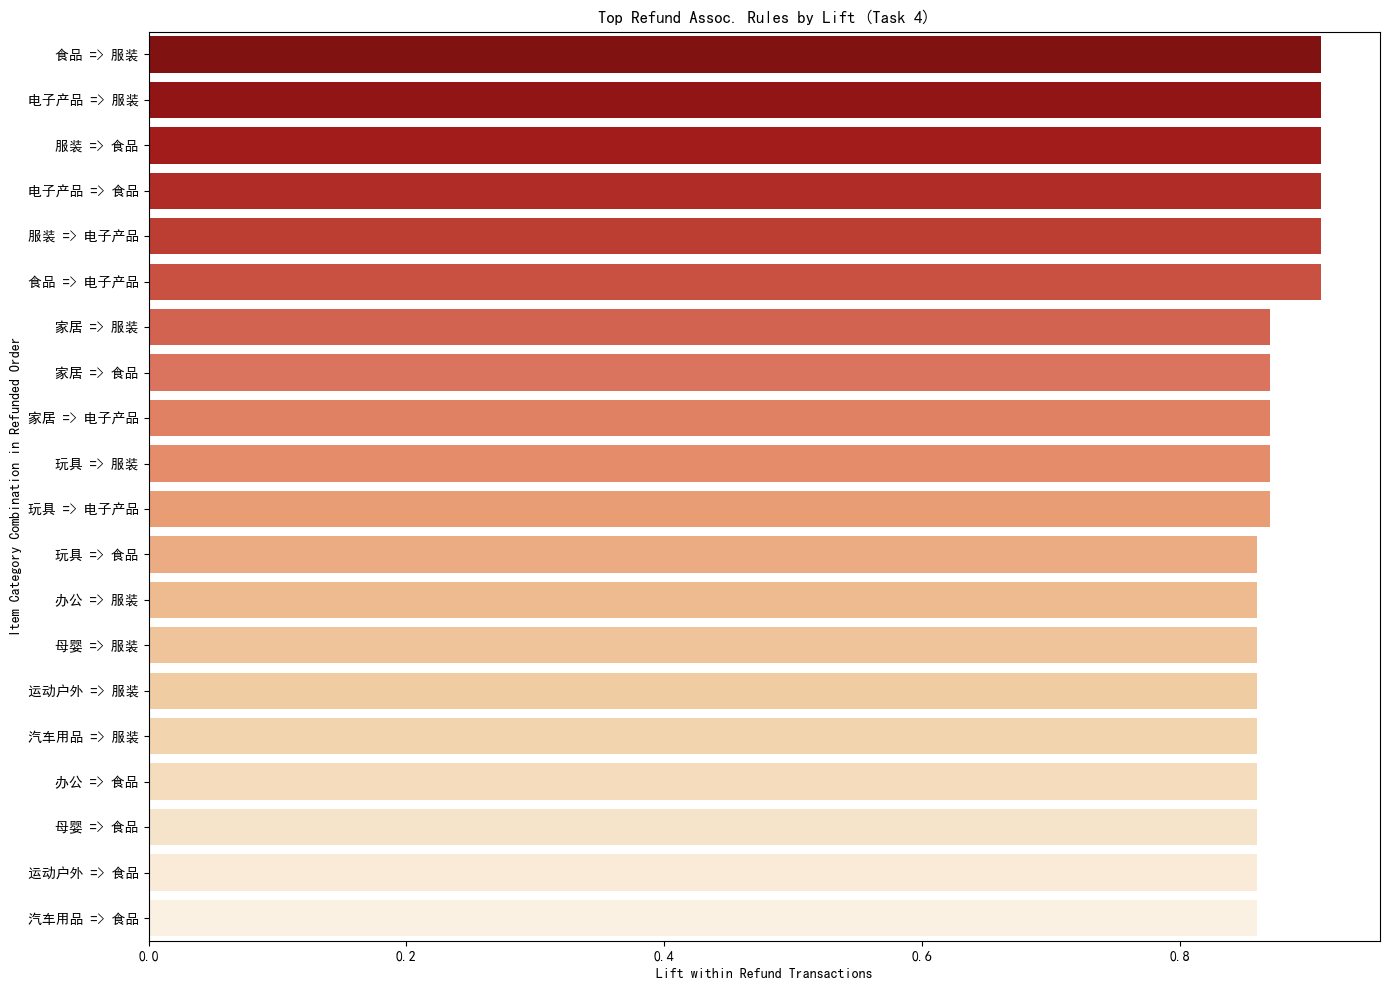

--- TASK 4 Complete ---


In [2]:
# ==============================================================================
# TASK 4: 退款模式分析
# ==============================================================================
print("\n\n--- TASK 4: Refund Pattern Analysis ---")
print("\nStep 4.1: Filtering transactions with '已退款' or '部分退款' status...")
refund_statuses_task4 = ["已退款", "部分退款"]
refund_transactions_df_task4 = df_final_preprocessed.where(col("payment_status").isin(refund_statuses_task4)).select("user_id", "purchase_date", "payment_method", "payment_status", "transaction_avg_price", "item_major_category").distinct()
print(f"Number of distinct rows in df_final_preprocessed related to refund statuses for grouping: {refund_transactions_df_task4.count()}")

print("\nStep 4.2: Building item baskets for refund-related transactions...")
refund_baskets_df_task4 = refund_transactions_df_task4.groupBy("user_id", "purchase_date", "payment_method", "payment_status", "transaction_avg_price").agg(collect_set("item_major_category").alias("items_in_refund_transaction"))
refund_baskets_filtered_df_task4 = refund_baskets_df_task4.where(size(col("items_in_refund_transaction")) >= 2).cache()
total_refund_transactions_for_fp_task4 = refund_baskets_filtered_df_task4.count()
print(f"Total refund transactions (with >= 2 distinct major categories) for FPGrowth (Task 4): {total_refund_transactions_for_fp_task4}")

if total_refund_transactions_for_fp_task4 > 0:
    refund_baskets_filtered_df_task4.select("items_in_refund_transaction").show(5, truncate=False)
    min_support_refund_task4 = 0.005; min_confidence_refund_task4 = 0.4
    print(f"\nStep 4.3: Running FPGrowth on refund transactions (minSupport={min_support_refund_task4}, minConfidence={min_confidence_refund_task4})...")
    fpGrowth_refund_task4 = FPGrowth(itemsCol="items_in_refund_transaction", minSupport=min_support_refund_task4, minConfidence=min_confidence_refund_task4)
    model_refund_task4 = fpGrowth_refund_task4.fit(refund_baskets_filtered_df_task4)
    
    print("\nStep 4.4: Extracting frequent itemsets and association rules from refund transactions...")
    # 频繁项集处理
    freq_itemsets_refund_df_task4_raw = model_refund_task4.freqItemsets
    freq_itemsets_refund_df_task4 = freq_itemsets_refund_df_task4_raw.withColumn(
        "support_percentage_in_refunds", round((col("freq") / lit(total_refund_transactions_for_fp_task4)) * 100, 3) # Use lit() for denominator
    ).orderBy(desc("freq"))
    print(f"\nFrequent Itemsets in Refund Transactions (Task 4):"); freq_itemsets_refund_df_task4.show(truncate=False)
    
    freq_itemsets_refund_for_csv_task4 = freq_itemsets_refund_df_task4.withColumn(
        "items_str", concat_ws(", ", col("items"))
    ).select("items_str", "freq", "support_percentage_in_refunds")
    freq_itemsets_refund_for_csv_task4.write.mode("overwrite").csv(os.path.join(tables_dir, "task4_refund_freq_itemsets.csv"), header=True)
    print(f"Task 4 Refund Frequent Itemsets saved to CSV at: {os.path.join(tables_dir, 'task4_refund_freq_itemsets.csv')}")

    # 关联规则处理
    rules_refund_df_task4_raw = model_refund_task4.associationRules
    rules_refund_df_task4 = rules_refund_df_task4_raw.withColumn(
        "rule_str_display", expr("concat_ws(' => ', antecedent, consequent)")
    ).withColumn(
        "support_percent_in_refunds", round(col("support") * 100, 3)
    ).withColumn(
        "confidence_percent", round(col("confidence") * 100, 2)
    ).withColumn(
        "lift_in_refunds", round(col("lift"), 2)
    ).select("rule_str_display", "antecedent", "consequent", "support_percent_in_refunds", "confidence_percent", "lift_in_refunds") \
    .orderBy(desc("confidence_percent"), desc("lift_in_refunds"))
    print(f"\nAssociation Rules from Refund Transactions (Task 4):"); rules_refund_df_task4.show(truncate=False)

    rules_refund_for_csv_task4 = rules_refund_df_task4.withColumn(
        "antecedent_str", concat_ws(", ", col("antecedent"))
    ).withColumn(
        "consequent_str", concat_ws(", ", col("consequent"))
    ).select("rule_str_display", "antecedent_str", "consequent_str", "support_percent_in_refunds", "confidence_percent", "lift_in_refunds")
    rules_refund_for_csv_task4.write.mode("overwrite").csv(os.path.join(tables_dir, "task4_refund_rules.csv"), header=True)
    print(f"Task 4 Refund Association Rules saved to CSV at: {os.path.join(tables_dir, 'task4_refund_rules.csv')}")
    
    num_rules_refund_task4 = rules_refund_df_task4.count() # Count on original rules DF
    print(f"Total association rules found from refund transactions (Task 4): {num_rules_refund_task4}")
    if num_rules_refund_task4 > 0:
        print("\nStep 4.5: Visualizing refund-related association rules...")
        rules_refund_pd_task4_conf = rules_refund_df_task4.limit(20).toPandas() # Use original rules DF for pandas conversion
        if not rules_refund_pd_task4_conf.empty:
            rules_refund_pd_task4_conf['rule_str_vis'] = rules_refund_pd_task4_conf['rule_str_display']
            plt.figure(figsize=(14, 10)); sns.barplot(x="confidence_percent", y="rule_str_vis", data=rules_refund_pd_task4_conf, palette="Reds_r")
            plt.title('Top Refund Assoc. Rules by Confidence (Task 4)'); plt.xlabel('Confidence (%) within Refund Transactions'); plt.ylabel('Item Category Combination in Refunded Order'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task4_refund_rules_confidence.png")); plt.show()
        
        rules_refund_pd_task4_lift = rules_refund_df_task4.orderBy(desc("lift_in_refunds"), desc("confidence_percent")).limit(20).toPandas()
        if not rules_refund_pd_task4_lift.empty:
            rules_refund_pd_task4_lift['rule_str_vis'] = rules_refund_pd_task4_lift['rule_str_display']
            plt.figure(figsize=(14, 10)); sns.barplot(x="lift_in_refunds", y="rule_str_vis", data=rules_refund_pd_task4_lift, palette="OrRd_r")
            plt.title('Top Refund Assoc. Rules by Lift (Task 4)'); plt.xlabel('Lift within Refund Transactions'); plt.ylabel('Item Category Combination in Refunded Order'); plt.tight_layout(); plt.savefig(os.path.join(charts_dir, "task4_refund_rules_lift.png")); plt.show()
    else: print("No refund rules found for Task 4 to visualize.")
    refund_baskets_filtered_df_task4.unpersist()
else: print("No refund transactions with >= 2 items for Task 4 FPGrowth.")
print("--- TASK 4 Complete ---")

In [3]:
# ==============================================================================
# 清理与停止
# ==============================================================================
df_final_preprocessed.unpersist()
print("\nAll tasks complete. Unpersisted df_final_preprocessed.")

print("\nStopping SparkSession...")
spark.stop()
print("SparkSession stopped.")


All tasks complete. Unpersisted df_final_preprocessed.

Stopping SparkSession...
SparkSession stopped.
